In [8]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.metrics import roc_curve, auc
from tqdm import tqdm
from backbone1 import DenseNet201
from backbone2 import ResNet152d
from dataloader import create_dataloader
from metric import Metric
from ctran2 import CTranEncoder
torch.cuda.empty_cache()
from sklearn.metrics import precision_recall_curve, roc_auc_score, f1_score
# from tabulate import tabulate
from torchsummary import summary

# Set device to GPU if available, else use CPU
device = torch.device("cuda:1")
print(f"Current device: {torch.cuda.get_device_name(torch.cuda.current_device())}" if torch.cuda.is_available() else "Current device: CPU")

Current device: NVIDIA GeForce RTX 2080 Ti


In [6]:
# Define hyperparameters
batch_size = 16
num_epochs = 200
learning_rate = 0.000001
image_size = 384
num_workers = 4
num_labels = 20
thresholds = [0.5] * num_labels
num_classes = 20
data_dir = '../data'

In [7]:
# Create dataloaders
train_dataloader = create_dataloader(data_dir=data_dir, batch_size=batch_size, num_workers=num_workers, size=image_size, phase='train')
val_dataloader = create_dataloader(data_dir=data_dir, batch_size=batch_size, num_workers=num_workers, size=image_size, phase='val')

384
384


In [9]:
# Define model and optimizer
backbone1 = ResNet152d(num_classes=num_classes, embed_dim = 960)
model1 = CTranEncoder(num_classes=num_classes, embed_dim=960, num_layers=6, num_heads=num_workers, backbone=backbone1)
model1.to(device)

# Define model and optimizer
backbone2 = DenseNet201(num_classes=num_classes, embed_dim = 960)
model2 = CTranEncoder(num_classes=num_classes, embed_dim=960, num_layers=6, num_heads=num_workers, backbone=backbone2)
model2.to(device)

# Wrap your model with DataParallel
model1 = nn.DataParallel(model1, device_ids=[0, 1, 2, 3])
model2 = nn.DataParallel(model2, device_ids=[0, 1, 2, 3])

criterion = nn.BCEWithLogitsLoss()

# Define your optimizers
# Combine the parameters of both models
params = list(model1.parameters()) + list(model2.parameters())

# Create a single optimizer
optimizer = torch.optim.AdamW(params, lr=5e-5, weight_decay=1e-6)

# Create a single scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
#scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3, epochs= num_epochs, steps_per_epoch=len(train_dataloader))

/home/deependra/project/rfmidc_pytorch/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/deependra/project/rfmidc_pytorch/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
summary(model1, input_size=(3, 384, 384))

Layer (type:depth-idx)                             Param #
├─CTranEncoder: 1-1                                --
|    └─ResNet152d: 2-1                             --
|    |    └─ResNet: 3-1                            58,163,040
|    |    └─Linear: 3-2                            1,967,040
|    |    └─Linear: 3-3                            18,451,200
|    └─TransformerEncoder: 2-2                     --
|    |    └─ModuleList: 3-4                        45,775,488
|    └─Linear: 2-3                                 19,220
|    └─Linear: 2-4                                 1,844,160
|    └─BatchNorm1d: 2-5                            2
Total params: 126,220,150
Trainable params: 126,220,150
Non-trainable params: 0


Layer (type:depth-idx)                             Param #
├─CTranEncoder: 1-1                                --
|    └─ResNet152d: 2-1                             --
|    |    └─ResNet: 3-1                            58,163,040
|    |    └─Linear: 3-2                            1,967,040
|    |    └─Linear: 3-3                            18,451,200
|    └─TransformerEncoder: 2-2                     --
|    |    └─ModuleList: 3-4                        45,775,488
|    └─Linear: 2-3                                 19,220
|    └─Linear: 2-4                                 1,844,160
|    └─BatchNorm1d: 2-5                            2
Total params: 126,220,150
Trainable params: 126,220,150
Non-trainable params: 0

In [12]:
summary(model2, input_size=(3, 384, 384))

Layer (type:depth-idx)                             Param #
├─CTranEncoder: 1-1                                --
|    └─DenseNet201: 2-1                            --
|    |    └─Sequential: 3-1                        18,092,928
|    |    └─AdaptiveAvgPool2d: 3-2                 --
|    |    └─Linear: 3-3                            1,844,160
|    |    └─Linear: 3-4                            18,451,200
|    └─TransformerEncoder: 2-2                     --
|    |    └─ModuleList: 3-5                        45,775,488
|    └─Linear: 2-3                                 19,220
|    └─Linear: 2-4                                 1,844,160
|    └─BatchNorm1d: 2-5                            2
Total params: 86,027,158
Trainable params: 86,027,158
Non-trainable params: 0


Layer (type:depth-idx)                             Param #
├─CTranEncoder: 1-1                                --
|    └─DenseNet201: 2-1                            --
|    |    └─Sequential: 3-1                        18,092,928
|    |    └─AdaptiveAvgPool2d: 3-2                 --
|    |    └─Linear: 3-3                            1,844,160
|    |    └─Linear: 3-4                            18,451,200
|    └─TransformerEncoder: 2-2                     --
|    |    └─ModuleList: 3-5                        45,775,488
|    └─Linear: 2-3                                 19,220
|    └─Linear: 2-4                                 1,844,160
|    └─BatchNorm1d: 2-5                            2
Total params: 86,027,158
Trainable params: 86,027,158
Non-trainable params: 0

In [ ]:
# Initialize Metric class
metric1 = Metric(num_classes=num_classes)
metric2 = Metric(num_classes=num_classes)

# create empty lists to store predicted probabilities and true labels for each epoch
val_preds_all, val_labels_all = [], []

# define the epochs at which to plot the ROC curve
roc_epochs = [5,10,20,30,40,50,60,70,80,90,100,120,140,160,180,200]

# create empty lists to store ROC data for each epoch
roc_fpr = []
roc_tpr = []
roc_auc = []
f1_arr = []
loss_arr = []
model_arr = []
max_ms = [0,0]
a,b = 0.4,0.6

# Train and evaluate model
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    print('-' * 10)

    # Train phase
    model1.train()
    model2.train()
    for images, labels in tqdm(train_dataloader):
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs1 = model1(images)
        loss1 = criterion(outputs1, labels) 
        outputs1 = torch.sigmoid(outputs1)
           
    
        # Forward pass for model2
        outputs2 = model2(images)
        loss2 = criterion(outputs2, labels)
        outputs2 = torch.sigmoid(outputs2)
         
        
        # Calculate weighted average loss
        loss = a * loss1 + b * loss2
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Compute metrics on train set
        with torch.no_grad():
            metric1.update(outputs1, labels,0)
            
        with torch.no_grad():
            metric2.update(outputs2, labels,0)
    
    # Print metrics on train set 1
    ml_f1_score, map_score, auc_score, ml_map_score, ml_auc_score, ml_score, bin_auc, model_score, bin_f1_score = metric2.compute(1)
    print("DenseNet201:\n",f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, ML mAP: {ml_map_score:.4f}, ML F1: {ml_f1_score:.4f}, ML AUC: {ml_auc_score:.4f}, ML Score: {ml_score:.4f}, Bin AUC: {bin_auc:.4f}, Model Score: {model_score:.4f}, Bin F1: {bin_f1_score:.4f}")
    
    # Print metrics on train set 2
    ml_f1_score, map_score, auc_score, ml_map_score, ml_auc_score, ml_score, bin_auc, model_score, bin_f1_score = metric1.compute(1)
    print("ResNet152d:\n",f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, ML mAP: {ml_map_score:.4f}, ML F1: {ml_f1_score:.4f}, ML AUC: {ml_auc_score:.4f}, ML Score: {ml_score:.4f}, Bin AUC: {bin_auc:.4f}, Model Score: {model_score:.4f}, Bin F1: {bin_f1_score:.4f}")
    
    # Reset Metric class for evaluation
    metric1.reset()
    metric2.reset()
    del images
    del labels
    del outputs1
    del outputs2
    torch.cuda.empty_cache() 

    # Evaluate model on validation set
    model1.eval()
    model2.eval()
    running_loss = 0.0
    val_preds, val_labels = [], []
    with torch.no_grad():
        for images, labels in tqdm(val_dataloader):
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs1 = model1(images)
            loss1 = criterion(outputs1, labels) 
            outputs1 = torch.sigmoid(outputs1)
               
    
            # Forward pass for model2
            outputs2 = model2(images)
            loss2 = criterion(outputs2, labels) 
            outputs2 = torch.sigmoid(outputs2)
            
        
            # Calculate weighted average loss
            loss = a * loss1 + b * loss2
            running_loss += loss.item()
            
            # Perform weighted average of model predictions
            weighted_outputs = a * outputs1 + b * outputs2

            # append the predicted probabilities and true labels to lists for calculating ROC AUC score later
            val_preds += weighted_outputs.tolist()
            val_labels += labels.tolist()
            metric1.update(weighted_outputs, labels,1)

 
        # Print metrics on validation set
        ml_f1_score, map_score, auc_score, ml_map_score, ml_auc_score, ml_score, bin_auc, model_score, bin_f1_score = metric1.compute(0)
        print(f"Val - Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, ML mAP: {ml_map_score:.4f}, ML F1: {ml_f1_score:.4f}, ML AUC: {ml_auc_score:.4f}, ML Score: {ml_score:.4f}, Bin AUC: {bin_auc:.4f}, Model Score: {model_score:.4f}, Bin F1: {bin_f1_score:.4f}")
        
        f1_arr.append(ml_f1_score)
        model_arr.append(model_score)
        loss_arr.append(running_loss / len(val_dataloader))
        
        if max_ms[0] < model_score: 
            max_ms[0] = model_score
            max_ms[1] = epoch

        # append the predicted probabilities and true labels for this epoch to the lists for all epochs
        val_preds_all.append(val_preds)
        val_labels_all.append(val_labels)

        # check if the current epoch is in the list of epochs to plot ROC curve
        if epoch+1 in roc_epochs:
            # calculate ROC curve and AUC score for validation set
            fpr, tpr, roc_thresholds = roc_curve(np.concatenate(val_labels_all).ravel(), np.concatenate(val_preds_all).ravel())
            roc_fpr.append(fpr)
            roc_tpr.append(tpr)
            roc_auc.append(auc(fpr, tpr))

        print() # empty line for spacing    
        
        # Reset Metric class for next epoch
        metric1.reset()
        del images
        del labels
        del outputs1
        del outputs2
        torch.cuda.empty_cache()   
    
    # Step the learning rate scheduler
    scheduler.step()     

Epoch 1/200
----------


100%|██████████| 111/111 [05:01<00:00,  2.71s/it]


DenseNet201:
 Epoch [1/200], Loss: 0.2764, ML mAP: 0.1810, ML F1: 0.0668, ML AUC: 0.6959, ML Score: 0.4384, Bin AUC: 0.6944, Model Score: 0.5664, Bin F1: 0.2500
ResNet152d:
 Epoch [1/200], Loss: 0.2764, ML mAP: 0.1151, ML F1: 0.0199, ML AUC: 0.5896, ML Score: 0.3524, Bin AUC: 0.6389, Model Score: 0.4956, Bin F1: 0.1538


100%|██████████| 28/28 [00:17<00:00,  1.62it/s]


Val - Epoch [1/200], Loss: 0.2201, ML mAP: 0.3498, ML F1: 0.0426, ML AUC: 0.8479, ML Score: 0.5988, Bin AUC: 0.7895, Model Score: 0.6942, Bin F1: 0.0000

Epoch 2/200
----------


100%|██████████| 111/111 [01:44<00:00,  1.06it/s]


DenseNet201:
 Epoch [2/200], Loss: 0.2384, ML mAP: 0.3310, ML F1: 0.1818, ML AUC: 0.8288, ML Score: 0.5799, Bin AUC: 1.0000, Model Score: 0.7899, Bin F1: 0.0000
ResNet152d:
 Epoch [2/200], Loss: 0.2384, ML mAP: 0.2271, ML F1: 0.0523, ML AUC: 0.7684, ML Score: 0.4978, Bin AUC: 0.8611, Model Score: 0.6794, Bin F1: 0.0000


100%|██████████| 28/28 [00:16<00:00,  1.71it/s]


Val - Epoch [2/200], Loss: 0.2026, ML mAP: 0.4374, ML F1: 0.2258, ML AUC: 0.8978, ML Score: 0.6676, Bin AUC: 0.5789, Model Score: 0.6233, Bin F1: 0.0000

Epoch 3/200
----------


100%|██████████| 111/111 [01:47<00:00,  1.03it/s]


DenseNet201:
 Epoch [3/200], Loss: 0.2893, ML mAP: 0.4775, ML F1: 0.3376, ML AUC: 0.8711, ML Score: 0.6743, Bin AUC: 1.0000, Model Score: 0.8371, Bin F1: 1.0000
ResNet152d:
 Epoch [3/200], Loss: 0.2893, ML mAP: 0.3733, ML F1: 0.1980, ML AUC: 0.8525, ML Score: 0.6129, Bin AUC: 1.0000, Model Score: 0.8064, Bin F1: 0.0000


100%|██████████| 28/28 [00:16<00:00,  1.67it/s]


Val - Epoch [3/200], Loss: 0.1954, ML mAP: 0.5182, ML F1: 0.4383, ML AUC: 0.9099, ML Score: 0.7140, Bin AUC: 0.7368, Model Score: 0.7254, Bin F1: 0.0000

Epoch 4/200
----------


100%|██████████| 111/111 [01:42<00:00,  1.08it/s]


DenseNet201:
 Epoch [4/200], Loss: 0.2955, ML mAP: 0.5583, ML F1: 0.4474, ML AUC: 0.9048, ML Score: 0.7315, Bin AUC: 1.0000, Model Score: 0.8658, Bin F1: 1.0000
ResNet152d:
 Epoch [4/200], Loss: 0.2955, ML mAP: 0.5034, ML F1: 0.3800, ML AUC: 0.8975, ML Score: 0.7005, Bin AUC: 1.0000, Model Score: 0.8502, Bin F1: 0.0000


100%|██████████| 28/28 [00:15<00:00,  1.84it/s]


Val - Epoch [4/200], Loss: 0.1993, ML mAP: 0.5710, ML F1: 0.4225, ML AUC: 0.9278, ML Score: 0.7494, Bin AUC: 0.7895, Model Score: 0.7694, Bin F1: 0.0000

Epoch 5/200
----------


100%|██████████| 111/111 [03:04<00:00,  1.66s/it]


DenseNet201:
 Epoch [5/200], Loss: 0.3150, ML mAP: 0.6623, ML F1: 0.5641, ML AUC: 0.9293, ML Score: 0.7958, Bin AUC: 0.5556, Model Score: 0.6757, Bin F1: 0.0000
ResNet152d:
 Epoch [5/200], Loss: 0.3150, ML mAP: 0.6087, ML F1: 0.5083, ML AUC: 0.9251, ML Score: 0.7669, Bin AUC: 0.9167, Model Score: 0.8418, Bin F1: 0.0000


100%|██████████| 28/28 [00:38<00:00,  1.37s/it]


Val - Epoch [5/200], Loss: 0.1849, ML mAP: 0.6084, ML F1: 0.4739, ML AUC: 0.9299, ML Score: 0.7691, Bin AUC: 1.0000, Model Score: 0.8846, Bin F1: 0.0000

Epoch 6/200
----------


100%|██████████| 111/111 [04:42<00:00,  2.55s/it]


DenseNet201:
 Epoch [6/200], Loss: 0.3588, ML mAP: 0.7403, ML F1: 0.6482, ML AUC: 0.9450, ML Score: 0.8427, Bin AUC: 0.9474, Model Score: 0.8950, Bin F1: 0.0000
ResNet152d:
 Epoch [6/200], Loss: 0.3588, ML mAP: 0.7083, ML F1: 0.6068, ML AUC: 0.9463, ML Score: 0.8273, Bin AUC: 0.9474, Model Score: 0.8873, Bin F1: 0.0000


100%|██████████| 28/28 [01:03<00:00,  2.28s/it]


Val - Epoch [6/200], Loss: 0.1772, ML mAP: 0.6364, ML F1: 0.4726, ML AUC: 0.9385, ML Score: 0.7874, Bin AUC: 0.9474, Model Score: 0.8674, Bin F1: 0.0000

Epoch 7/200
----------


100%|██████████| 111/111 [05:37<00:00,  3.04s/it]


DenseNet201:
 Epoch [7/200], Loss: 0.3861, ML mAP: 0.7912, ML F1: 0.6924, ML AUC: 0.9560, ML Score: 0.8736, Bin AUC: 1.0000, Model Score: 0.9368, Bin F1: 1.0000
ResNet152d:
 Epoch [7/200], Loss: 0.3861, ML mAP: 0.7668, ML F1: 0.6599, ML AUC: 0.9607, ML Score: 0.8637, Bin AUC: 1.0000, Model Score: 0.9319, Bin F1: 0.6667


100%|██████████| 28/28 [01:02<00:00,  2.24s/it]


Val - Epoch [7/200], Loss: 0.1443, ML mAP: 0.6482, ML F1: 0.5629, ML AUC: 0.9454, ML Score: 0.7968, Bin AUC: 1.0000, Model Score: 0.8984, Bin F1: 0.0000

Epoch 8/200
----------


100%|██████████| 111/111 [04:57<00:00,  2.68s/it]


DenseNet201:
 Epoch [8/200], Loss: 0.3478, ML mAP: 0.8147, ML F1: 0.7272, ML AUC: 0.9594, ML Score: 0.8870, Bin AUC: 0.9444, Model Score: 0.9157, Bin F1: 0.5000
ResNet152d:
 Epoch [8/200], Loss: 0.3478, ML mAP: 0.8018, ML F1: 0.7034, ML AUC: 0.9657, ML Score: 0.8837, Bin AUC: 0.9167, Model Score: 0.9002, Bin F1: 0.0000


100%|██████████| 28/28 [00:36<00:00,  1.29s/it]


Val - Epoch [8/200], Loss: 0.1473, ML mAP: 0.6544, ML F1: 0.5711, ML AUC: 0.9438, ML Score: 0.7991, Bin AUC: 0.9474, Model Score: 0.8732, Bin F1: 0.0000

Epoch 9/200
----------


100%|██████████| 111/111 [03:39<00:00,  1.98s/it]


DenseNet201:
 Epoch [9/200], Loss: 0.2503, ML mAP: 0.8509, ML F1: 0.7676, ML AUC: 0.9701, ML Score: 0.9105, Bin AUC: 0.6667, Model Score: 0.7886, Bin F1: 0.0000
ResNet152d:
 Epoch [9/200], Loss: 0.2503, ML mAP: 0.8425, ML F1: 0.7534, ML AUC: 0.9717, ML Score: 0.9071, Bin AUC: 0.8611, Model Score: 0.8841, Bin F1: 0.0000


100%|██████████| 28/28 [00:37<00:00,  1.34s/it]


Val - Epoch [9/200], Loss: 0.1338, ML mAP: 0.6756, ML F1: 0.6073, ML AUC: 0.9476, ML Score: 0.8116, Bin AUC: 0.9474, Model Score: 0.8795, Bin F1: 0.0000

Epoch 10/200
----------


100%|██████████| 111/111 [03:40<00:00,  1.99s/it]


DenseNet201:
 Epoch [10/200], Loss: 0.2285, ML mAP: 0.8647, ML F1: 0.7836, ML AUC: 0.9734, ML Score: 0.9190, Bin AUC: 0.8947, Model Score: 0.9069, Bin F1: 0.0000
ResNet152d:
 Epoch [10/200], Loss: 0.2285, ML mAP: 0.8581, ML F1: 0.7659, ML AUC: 0.9755, ML Score: 0.9168, Bin AUC: 1.0000, Model Score: 0.9584, Bin F1: 1.0000


100%|██████████| 28/28 [00:36<00:00,  1.31s/it]


Val - Epoch [10/200], Loss: 0.1496, ML mAP: 0.6605, ML F1: 0.5892, ML AUC: 0.9474, ML Score: 0.8039, Bin AUC: 1.0000, Model Score: 0.9020, Bin F1: 0.0000

Epoch 11/200
----------


100%|██████████| 111/111 [03:36<00:00,  1.95s/it]


DenseNet201:
 Epoch [11/200], Loss: 0.2115, ML mAP: 0.7701, ML F1: 0.6939, ML AUC: 0.9545, ML Score: 0.8623, Bin AUC: 1.0000, Model Score: 0.9311, Bin F1: 1.0000
ResNet152d:
 Epoch [11/200], Loss: 0.2115, ML mAP: 0.7821, ML F1: 0.6943, ML AUC: 0.9629, ML Score: 0.8725, Bin AUC: 1.0000, Model Score: 0.9362, Bin F1: 0.0000


100%|██████████| 28/28 [00:35<00:00,  1.27s/it]


Val - Epoch [11/200], Loss: 0.1467, ML mAP: 0.6147, ML F1: 0.5502, ML AUC: 0.9296, ML Score: 0.7722, Bin AUC: 1.0000, Model Score: 0.8861, Bin F1: 0.0000

Epoch 12/200
----------


100%|██████████| 111/111 [02:34<00:00,  1.39s/it]


DenseNet201:
 Epoch [12/200], Loss: 0.2808, ML mAP: 0.7644, ML F1: 0.6760, ML AUC: 0.9551, ML Score: 0.8598, Bin AUC: 1.0000, Model Score: 0.9299, Bin F1: 1.0000
ResNet152d:
 Epoch [12/200], Loss: 0.2808, ML mAP: 0.8064, ML F1: 0.7202, ML AUC: 0.9652, ML Score: 0.8858, Bin AUC: 0.9722, Model Score: 0.9290, Bin F1: 0.6667


100%|██████████| 28/28 [00:14<00:00,  1.89it/s]


Val - Epoch [12/200], Loss: 0.1902, ML mAP: 0.6405, ML F1: 0.4951, ML AUC: 0.9430, ML Score: 0.7917, Bin AUC: 1.0000, Model Score: 0.8959, Bin F1: 1.0000

Epoch 13/200
----------


100%|██████████| 111/111 [01:42<00:00,  1.09it/s]


DenseNet201:
 Epoch [13/200], Loss: 0.2257, ML mAP: 0.7880, ML F1: 0.7133, ML AUC: 0.9584, ML Score: 0.8732, Bin AUC: 0.8333, Model Score: 0.8533, Bin F1: 0.6667
ResNet152d:
 Epoch [13/200], Loss: 0.2257, ML mAP: 0.8410, ML F1: 0.7686, ML AUC: 0.9715, ML Score: 0.9063, Bin AUC: 1.0000, Model Score: 0.9531, Bin F1: 0.0000


100%|██████████| 28/28 [00:14<00:00,  1.91it/s]


Val - Epoch [13/200], Loss: 0.1880, ML mAP: 0.6155, ML F1: 0.5305, ML AUC: 0.9351, ML Score: 0.7753, Bin AUC: 1.0000, Model Score: 0.8877, Bin F1: 0.0000

Epoch 14/200
----------


100%|██████████| 111/111 [01:42<00:00,  1.08it/s]


DenseNet201:
 Epoch [14/200], Loss: 0.2522, ML mAP: 0.8252, ML F1: 0.7457, ML AUC: 0.9681, ML Score: 0.8966, Bin AUC: 0.8333, Model Score: 0.8650, Bin F1: 0.0000
ResNet152d:
 Epoch [14/200], Loss: 0.2522, ML mAP: 0.8825, ML F1: 0.8144, ML AUC: 0.9810, ML Score: 0.9318, Bin AUC: 0.8333, Model Score: 0.8825, Bin F1: 0.0000


100%|██████████| 28/28 [00:14<00:00,  1.87it/s]


Val - Epoch [14/200], Loss: 0.1775, ML mAP: 0.6556, ML F1: 0.5778, ML AUC: 0.9351, ML Score: 0.7953, Bin AUC: 1.0000, Model Score: 0.8977, Bin F1: 1.0000

Epoch 15/200
----------


100%|██████████| 111/111 [01:43<00:00,  1.07it/s]


DenseNet201:
 Epoch [15/200], Loss: 0.2798, ML mAP: 0.8463, ML F1: 0.7778, ML AUC: 0.9723, ML Score: 0.9093, Bin AUC: 1.0000, Model Score: 0.9546, Bin F1: 0.0000
ResNet152d:
 Epoch [15/200], Loss: 0.2798, ML mAP: 0.8938, ML F1: 0.8218, ML AUC: 0.9830, ML Score: 0.9384, Bin AUC: 0.9474, Model Score: 0.9429, Bin F1: 0.6667


100%|██████████| 28/28 [00:14<00:00,  1.90it/s]


Val - Epoch [15/200], Loss: 0.1735, ML mAP: 0.6570, ML F1: 0.5758, ML AUC: 0.9446, ML Score: 0.8008, Bin AUC: 1.0000, Model Score: 0.9004, Bin F1: 1.0000

Epoch 16/200
----------


100%|██████████| 111/111 [01:42<00:00,  1.08it/s]


DenseNet201:
 Epoch [16/200], Loss: 0.2615, ML mAP: 0.8641, ML F1: 0.7861, ML AUC: 0.9742, ML Score: 0.9192, Bin AUC: 1.0000, Model Score: 0.9596, Bin F1: 0.8000
ResNet152d:
 Epoch [16/200], Loss: 0.2615, ML mAP: 0.9103, ML F1: 0.8445, ML AUC: 0.9861, ML Score: 0.9482, Bin AUC: 1.0000, Model Score: 0.9741, Bin F1: 0.8000


100%|██████████| 28/28 [00:14<00:00,  1.89it/s]


Val - Epoch [16/200], Loss: 0.1807, ML mAP: 0.6731, ML F1: 0.5874, ML AUC: 0.9404, ML Score: 0.8068, Bin AUC: 1.0000, Model Score: 0.9034, Bin F1: 0.0000

Epoch 17/200
----------


100%|██████████| 111/111 [01:43<00:00,  1.07it/s]


DenseNet201:
 Epoch [17/200], Loss: 0.2919, ML mAP: 0.8833, ML F1: 0.8172, ML AUC: 0.9787, ML Score: 0.9310, Bin AUC: 1.0000, Model Score: 0.9655, Bin F1: 1.0000
ResNet152d:
 Epoch [17/200], Loss: 0.2919, ML mAP: 0.9313, ML F1: 0.8739, ML AUC: 0.9895, ML Score: 0.9604, Bin AUC: 1.0000, Model Score: 0.9802, Bin F1: 1.0000


100%|██████████| 28/28 [00:15<00:00,  1.79it/s]


Val - Epoch [17/200], Loss: 0.1737, ML mAP: 0.6549, ML F1: 0.5483, ML AUC: 0.9417, ML Score: 0.7983, Bin AUC: 1.0000, Model Score: 0.8991, Bin F1: 0.0000

Epoch 18/200
----------


100%|██████████| 111/111 [01:40<00:00,  1.10it/s]


DenseNet201:
 Epoch [18/200], Loss: 0.2262, ML mAP: 0.9025, ML F1: 0.8317, ML AUC: 0.9842, ML Score: 0.9433, Bin AUC: 1.0000, Model Score: 0.9717, Bin F1: 1.0000
ResNet152d:
 Epoch [18/200], Loss: 0.2262, ML mAP: 0.9453, ML F1: 0.8871, ML AUC: 0.9924, ML Score: 0.9689, Bin AUC: 1.0000, Model Score: 0.9844, Bin F1: 1.0000


100%|██████████| 28/28 [00:14<00:00,  1.89it/s]


Val - Epoch [18/200], Loss: 0.2006, ML mAP: 0.6631, ML F1: 0.5863, ML AUC: 0.9465, ML Score: 0.8048, Bin AUC: 1.0000, Model Score: 0.9024, Bin F1: 0.0000

Epoch 19/200
----------


100%|██████████| 111/111 [02:04<00:00,  1.12s/it]


DenseNet201:
 Epoch [19/200], Loss: 0.2484, ML mAP: 0.9185, ML F1: 0.8580, ML AUC: 0.9864, ML Score: 0.9524, Bin AUC: 1.0000, Model Score: 0.9762, Bin F1: 1.0000
ResNet152d:
 Epoch [19/200], Loss: 0.2484, ML mAP: 0.9525, ML F1: 0.9055, ML AUC: 0.9933, ML Score: 0.9729, Bin AUC: 1.0000, Model Score: 0.9864, Bin F1: 1.0000


100%|██████████| 28/28 [00:15<00:00,  1.82it/s]


Val - Epoch [19/200], Loss: 0.2175, ML mAP: 0.6760, ML F1: 0.6105, ML AUC: 0.9440, ML Score: 0.8100, Bin AUC: 1.0000, Model Score: 0.9050, Bin F1: 0.0000

Epoch 20/200
----------


100%|██████████| 111/111 [03:05<00:00,  1.67s/it]


DenseNet201:
 Epoch [20/200], Loss: 0.2974, ML mAP: 0.9246, ML F1: 0.8642, ML AUC: 0.9875, ML Score: 0.9560, Bin AUC: 0.9412, Model Score: 0.9486, Bin F1: 0.4000
ResNet152d:
 Epoch [20/200], Loss: 0.2974, ML mAP: 0.9594, ML F1: 0.9093, ML AUC: 0.9945, ML Score: 0.9769, Bin AUC: 1.0000, Model Score: 0.9885, Bin F1: 0.8000


100%|██████████| 28/28 [00:14<00:00,  1.96it/s]


Val - Epoch [20/200], Loss: 0.1978, ML mAP: 0.6775, ML F1: 0.6154, ML AUC: 0.9428, ML Score: 0.8101, Bin AUC: 1.0000, Model Score: 0.9051, Bin F1: 0.0000

Epoch 21/200
----------


100%|██████████| 111/111 [01:52<00:00,  1.01s/it]


DenseNet201:
 Epoch [21/200], Loss: 0.3088, ML mAP: 0.9367, ML F1: 0.8813, ML AUC: 0.9880, ML Score: 0.9623, Bin AUC: 1.0000, Model Score: 0.9812, Bin F1: 1.0000
ResNet152d:
 Epoch [21/200], Loss: 0.3088, ML mAP: 0.9619, ML F1: 0.9195, ML AUC: 0.9948, ML Score: 0.9784, Bin AUC: 1.0000, Model Score: 0.9892, Bin F1: 1.0000


100%|██████████| 28/28 [00:41<00:00,  1.49s/it]


Val - Epoch [21/200], Loss: 0.1984, ML mAP: 0.6778, ML F1: 0.6202, ML AUC: 0.9490, ML Score: 0.8134, Bin AUC: 0.8947, Model Score: 0.8541, Bin F1: 0.0000

Epoch 22/200
----------


100%|██████████| 111/111 [04:29<00:00,  2.42s/it]


DenseNet201:
 Epoch [22/200], Loss: 0.2378, ML mAP: 0.9445, ML F1: 0.8930, ML AUC: 0.9913, ML Score: 0.9679, Bin AUC: 1.0000, Model Score: 0.9839, Bin F1: 1.0000
ResNet152d:
 Epoch [22/200], Loss: 0.2378, ML mAP: 0.9670, ML F1: 0.9260, ML AUC: 0.9955, ML Score: 0.9813, Bin AUC: 1.0000, Model Score: 0.9906, Bin F1: 1.0000


100%|██████████| 28/28 [00:37<00:00,  1.34s/it]


Val - Epoch [22/200], Loss: 0.1797, ML mAP: 0.6898, ML F1: 0.6319, ML AUC: 0.9484, ML Score: 0.8191, Bin AUC: 1.0000, Model Score: 0.9095, Bin F1: 1.0000

Epoch 23/200
----------


100%|██████████| 111/111 [04:23<00:00,  2.38s/it]


DenseNet201:
 Epoch [23/200], Loss: 0.2398, ML mAP: 0.9515, ML F1: 0.9005, ML AUC: 0.9922, ML Score: 0.9719, Bin AUC: 1.0000, Model Score: 0.9859, Bin F1: 1.0000
ResNet152d:
 Epoch [23/200], Loss: 0.2398, ML mAP: 0.9737, ML F1: 0.9358, ML AUC: 0.9966, ML Score: 0.9851, Bin AUC: 1.0000, Model Score: 0.9926, Bin F1: 1.0000


100%|██████████| 28/28 [00:25<00:00,  1.09it/s]


Val - Epoch [23/200], Loss: 0.1852, ML mAP: 0.6897, ML F1: 0.6554, ML AUC: 0.9478, ML Score: 0.8188, Bin AUC: 0.9474, Model Score: 0.8831, Bin F1: 0.0000

Epoch 24/200
----------


100%|██████████| 111/111 [02:32<00:00,  1.38s/it]


DenseNet201:
 Epoch [24/200], Loss: 0.2138, ML mAP: 0.9489, ML F1: 0.8977, ML AUC: 0.9906, ML Score: 0.9697, Bin AUC: 1.0000, Model Score: 0.9849, Bin F1: 1.0000
ResNet152d:
 Epoch [24/200], Loss: 0.2138, ML mAP: 0.9734, ML F1: 0.9366, ML AUC: 0.9958, ML Score: 0.9846, Bin AUC: 1.0000, Model Score: 0.9923, Bin F1: 1.0000


100%|██████████| 28/28 [00:21<00:00,  1.33it/s]


Val - Epoch [24/200], Loss: 0.1964, ML mAP: 0.6745, ML F1: 0.6445, ML AUC: 0.9491, ML Score: 0.8118, Bin AUC: 1.0000, Model Score: 0.9059, Bin F1: 1.0000

Epoch 25/200
----------


100%|██████████| 111/111 [02:32<00:00,  1.37s/it]


DenseNet201:
 Epoch [25/200], Loss: 0.2208, ML mAP: 0.9629, ML F1: 0.9222, ML AUC: 0.9948, ML Score: 0.9788, Bin AUC: 1.0000, Model Score: 0.9894, Bin F1: 1.0000
ResNet152d:
 Epoch [25/200], Loss: 0.2208, ML mAP: 0.9793, ML F1: 0.9449, ML AUC: 0.9972, ML Score: 0.9882, Bin AUC: 1.0000, Model Score: 0.9941, Bin F1: 1.0000


100%|██████████| 28/28 [00:20<00:00,  1.34it/s]


Val - Epoch [25/200], Loss: 0.1939, ML mAP: 0.6845, ML F1: 0.6312, ML AUC: 0.9506, ML Score: 0.8176, Bin AUC: 1.0000, Model Score: 0.9088, Bin F1: 1.0000

Epoch 26/200
----------


100%|██████████| 111/111 [02:32<00:00,  1.37s/it]


DenseNet201:
 Epoch [26/200], Loss: 0.2043, ML mAP: 0.9601, ML F1: 0.9139, ML AUC: 0.9932, ML Score: 0.9766, Bin AUC: 1.0000, Model Score: 0.9883, Bin F1: 1.0000
ResNet152d:
 Epoch [26/200], Loss: 0.2043, ML mAP: 0.9784, ML F1: 0.9431, ML AUC: 0.9972, ML Score: 0.9878, Bin AUC: 1.0000, Model Score: 0.9939, Bin F1: 1.0000


100%|██████████| 28/28 [00:21<00:00,  1.33it/s]


Val - Epoch [26/200], Loss: 0.1854, ML mAP: 0.6874, ML F1: 0.6402, ML AUC: 0.9497, ML Score: 0.8186, Bin AUC: 1.0000, Model Score: 0.9093, Bin F1: 1.0000

Epoch 27/200
----------


100%|██████████| 111/111 [02:35<00:00,  1.40s/it]


DenseNet201:
 Epoch [27/200], Loss: 0.2556, ML mAP: 0.9670, ML F1: 0.9232, ML AUC: 0.9952, ML Score: 0.9811, Bin AUC: 0.9722, Model Score: 0.9767, Bin F1: 0.6667
ResNet152d:
 Epoch [27/200], Loss: 0.2556, ML mAP: 0.9868, ML F1: 0.9544, ML AUC: 0.9984, ML Score: 0.9926, Bin AUC: 1.0000, Model Score: 0.9963, Bin F1: 1.0000


100%|██████████| 28/28 [00:22<00:00,  1.27it/s]


Val - Epoch [27/200], Loss: 0.1850, ML mAP: 0.6870, ML F1: 0.6299, ML AUC: 0.9512, ML Score: 0.8191, Bin AUC: 1.0000, Model Score: 0.9095, Bin F1: 1.0000

Epoch 28/200
----------


100%|██████████| 111/111 [02:29<00:00,  1.35s/it]


DenseNet201:
 Epoch [28/200], Loss: 0.3122, ML mAP: 0.9636, ML F1: 0.9274, ML AUC: 0.9948, ML Score: 0.9792, Bin AUC: 1.0000, Model Score: 0.9896, Bin F1: 1.0000
ResNet152d:
 Epoch [28/200], Loss: 0.3122, ML mAP: 0.9806, ML F1: 0.9537, ML AUC: 0.9977, ML Score: 0.9891, Bin AUC: 1.0000, Model Score: 0.9946, Bin F1: 1.0000


100%|██████████| 28/28 [00:25<00:00,  1.12it/s]


Val - Epoch [28/200], Loss: 0.1977, ML mAP: 0.6907, ML F1: 0.6326, ML AUC: 0.9535, ML Score: 0.8221, Bin AUC: 1.0000, Model Score: 0.9110, Bin F1: 1.0000

Epoch 29/200
----------


100%|██████████| 111/111 [02:54<00:00,  1.57s/it]


DenseNet201:
 Epoch [29/200], Loss: 0.2104, ML mAP: 0.9736, ML F1: 0.9314, ML AUC: 0.9955, ML Score: 0.9845, Bin AUC: 1.0000, Model Score: 0.9923, Bin F1: 1.0000
ResNet152d:
 Epoch [29/200], Loss: 0.2104, ML mAP: 0.9874, ML F1: 0.9607, ML AUC: 0.9986, ML Score: 0.9930, Bin AUC: 1.0000, Model Score: 0.9965, Bin F1: 1.0000


100%|██████████| 28/28 [00:55<00:00,  1.96s/it]


Val - Epoch [29/200], Loss: 0.1881, ML mAP: 0.6859, ML F1: 0.6283, ML AUC: 0.9517, ML Score: 0.8188, Bin AUC: 1.0000, Model Score: 0.9094, Bin F1: 1.0000

Epoch 30/200
----------


100%|██████████| 111/111 [04:54<00:00,  2.65s/it]


DenseNet201:
 Epoch [30/200], Loss: 0.1824, ML mAP: 0.9693, ML F1: 0.9235, ML AUC: 0.9958, ML Score: 0.9825, Bin AUC: 1.0000, Model Score: 0.9913, Bin F1: 1.0000
ResNet152d:
 Epoch [30/200], Loss: 0.1824, ML mAP: 0.9848, ML F1: 0.9520, ML AUC: 0.9984, ML Score: 0.9916, Bin AUC: 1.0000, Model Score: 0.9958, Bin F1: 1.0000


100%|██████████| 28/28 [00:53<00:00,  1.91s/it]


Val - Epoch [30/200], Loss: 0.2074, ML mAP: 0.6881, ML F1: 0.6564, ML AUC: 0.9507, ML Score: 0.8194, Bin AUC: 1.0000, Model Score: 0.9097, Bin F1: 1.0000

Epoch 31/200
----------


100%|██████████| 111/111 [04:46<00:00,  2.58s/it]


DenseNet201:
 Epoch [31/200], Loss: 0.2075, ML mAP: 0.9209, ML F1: 0.8689, ML AUC: 0.9853, ML Score: 0.9531, Bin AUC: 1.0000, Model Score: 0.9765, Bin F1: 0.8000
ResNet152d:
 Epoch [31/200], Loss: 0.2075, ML mAP: 0.9575, ML F1: 0.9112, ML AUC: 0.9943, ML Score: 0.9759, Bin AUC: 1.0000, Model Score: 0.9880, Bin F1: 0.8000


100%|██████████| 28/28 [00:53<00:00,  1.90s/it]


Val - Epoch [31/200], Loss: 0.2545, ML mAP: 0.6548, ML F1: 0.5423, ML AUC: 0.9334, ML Score: 0.7941, Bin AUC: 0.9474, Model Score: 0.8707, Bin F1: 0.0000

Epoch 32/200
----------


100%|██████████| 111/111 [03:18<00:00,  1.78s/it]


DenseNet201:
 Epoch [32/200], Loss: 0.2889, ML mAP: 0.9019, ML F1: 0.8373, ML AUC: 0.9814, ML Score: 0.9416, Bin AUC: 1.0000, Model Score: 0.9708, Bin F1: 0.0000
ResNet152d:
 Epoch [32/200], Loss: 0.2889, ML mAP: 0.9472, ML F1: 0.8972, ML AUC: 0.9906, ML Score: 0.9689, Bin AUC: 0.9474, Model Score: 0.9581, Bin F1: 0.0000


100%|██████████| 28/28 [00:24<00:00,  1.13it/s]


Val - Epoch [32/200], Loss: 0.2550, ML mAP: 0.6598, ML F1: 0.5837, ML AUC: 0.9387, ML Score: 0.7993, Bin AUC: 1.0000, Model Score: 0.8996, Bin F1: 1.0000

Epoch 33/200
----------


100%|██████████| 111/111 [02:52<00:00,  1.56s/it]


DenseNet201:
 Epoch [33/200], Loss: 0.2242, ML mAP: 0.9009, ML F1: 0.8370, ML AUC: 0.9845, ML Score: 0.9427, Bin AUC: 0.9444, Model Score: 0.9436, Bin F1: 0.6667
ResNet152d:
 Epoch [33/200], Loss: 0.2242, ML mAP: 0.9592, ML F1: 0.9126, ML AUC: 0.9945, ML Score: 0.9768, Bin AUC: 1.0000, Model Score: 0.9884, Bin F1: 1.0000


100%|██████████| 28/28 [00:23<00:00,  1.20it/s]


Val - Epoch [33/200], Loss: 0.2159, ML mAP: 0.6713, ML F1: 0.6223, ML AUC: 0.9383, ML Score: 0.8048, Bin AUC: 1.0000, Model Score: 0.9024, Bin F1: 1.0000

Epoch 34/200
----------


100%|██████████| 111/111 [02:41<00:00,  1.46s/it]


DenseNet201:
 Epoch [34/200], Loss: 0.2771, ML mAP: 0.9249, ML F1: 0.8628, ML AUC: 0.9886, ML Score: 0.9568, Bin AUC: 0.9444, Model Score: 0.9506, Bin F1: 0.5000
ResNet152d:
 Epoch [34/200], Loss: 0.2771, ML mAP: 0.9612, ML F1: 0.9141, ML AUC: 0.9946, ML Score: 0.9779, Bin AUC: 1.0000, Model Score: 0.9889, Bin F1: 1.0000


100%|██████████| 28/28 [00:25<00:00,  1.11it/s]


Val - Epoch [34/200], Loss: 0.2521, ML mAP: 0.6596, ML F1: 0.5947, ML AUC: 0.9388, ML Score: 0.7992, Bin AUC: 1.0000, Model Score: 0.8996, Bin F1: 1.0000

Epoch 35/200
----------


100%|██████████| 111/111 [02:42<00:00,  1.46s/it]


DenseNet201:
 Epoch [35/200], Loss: 0.2262, ML mAP: 0.9328, ML F1: 0.8803, ML AUC: 0.9888, ML Score: 0.9608, Bin AUC: 1.0000, Model Score: 0.9804, Bin F1: 1.0000
ResNet152d:
 Epoch [35/200], Loss: 0.2262, ML mAP: 0.9670, ML F1: 0.9181, ML AUC: 0.9955, ML Score: 0.9812, Bin AUC: 1.0000, Model Score: 0.9906, Bin F1: 1.0000


100%|██████████| 28/28 [00:24<00:00,  1.17it/s]


Val - Epoch [35/200], Loss: 0.2067, ML mAP: 0.6819, ML F1: 0.6298, ML AUC: 0.9475, ML Score: 0.8147, Bin AUC: 1.0000, Model Score: 0.9074, Bin F1: 0.6667

Epoch 36/200
----------


100%|██████████| 111/111 [01:57<00:00,  1.06s/it]


DenseNet201:
 Epoch [36/200], Loss: 0.1897, ML mAP: 0.9313, ML F1: 0.8707, ML AUC: 0.9887, ML Score: 0.9600, Bin AUC: 1.0000, Model Score: 0.9800, Bin F1: 1.0000
ResNet152d:
 Epoch [36/200], Loss: 0.1897, ML mAP: 0.9600, ML F1: 0.9155, ML AUC: 0.9944, ML Score: 0.9772, Bin AUC: 1.0000, Model Score: 0.9886, Bin F1: 1.0000


100%|██████████| 28/28 [00:15<00:00,  1.80it/s]


Val - Epoch [36/200], Loss: 0.2682, ML mAP: 0.6691, ML F1: 0.6018, ML AUC: 0.9490, ML Score: 0.8090, Bin AUC: 1.0000, Model Score: 0.9045, Bin F1: 1.0000

Epoch 37/200
----------


100%|██████████| 111/111 [01:41<00:00,  1.10it/s]


DenseNet201:
 Epoch [37/200], Loss: 0.2256, ML mAP: 0.9311, ML F1: 0.8806, ML AUC: 0.9891, ML Score: 0.9601, Bin AUC: 1.0000, Model Score: 0.9801, Bin F1: 1.0000
ResNet152d:
 Epoch [37/200], Loss: 0.2256, ML mAP: 0.9679, ML F1: 0.9262, ML AUC: 0.9952, ML Score: 0.9816, Bin AUC: 1.0000, Model Score: 0.9908, Bin F1: 1.0000


100%|██████████| 28/28 [00:15<00:00,  1.83it/s]


Val - Epoch [37/200], Loss: 0.2499, ML mAP: 0.6701, ML F1: 0.5584, ML AUC: 0.9484, ML Score: 0.8092, Bin AUC: 0.9474, Model Score: 0.8783, Bin F1: 0.0000

Epoch 38/200
----------


100%|██████████| 111/111 [01:36<00:00,  1.15it/s]


DenseNet201:
 Epoch [38/200], Loss: 0.2506, ML mAP: 0.9355, ML F1: 0.8799, ML AUC: 0.9900, ML Score: 0.9627, Bin AUC: 1.0000, Model Score: 0.9814, Bin F1: 1.0000
ResNet152d:
 Epoch [38/200], Loss: 0.2506, ML mAP: 0.9669, ML F1: 0.9197, ML AUC: 0.9961, ML Score: 0.9815, Bin AUC: 1.0000, Model Score: 0.9908, Bin F1: 1.0000


100%|██████████| 28/28 [00:15<00:00,  1.85it/s]


Val - Epoch [38/200], Loss: 0.2169, ML mAP: 0.6810, ML F1: 0.6266, ML AUC: 0.9425, ML Score: 0.8117, Bin AUC: 1.0000, Model Score: 0.9059, Bin F1: 1.0000

Epoch 39/200
----------


100%|██████████| 111/111 [01:36<00:00,  1.15it/s]


DenseNet201:
 Epoch [39/200], Loss: 0.2253, ML mAP: 0.9356, ML F1: 0.8791, ML AUC: 0.9898, ML Score: 0.9627, Bin AUC: 1.0000, Model Score: 0.9814, Bin F1: 1.0000
ResNet152d:
 Epoch [39/200], Loss: 0.2253, ML mAP: 0.9685, ML F1: 0.9311, ML AUC: 0.9962, ML Score: 0.9823, Bin AUC: 1.0000, Model Score: 0.9912, Bin F1: 1.0000


100%|██████████| 28/28 [00:15<00:00,  1.84it/s]


Val - Epoch [39/200], Loss: 0.1919, ML mAP: 0.6991, ML F1: 0.6617, ML AUC: 0.9439, ML Score: 0.8215, Bin AUC: 1.0000, Model Score: 0.9108, Bin F1: 1.0000

Epoch 40/200
----------


100%|██████████| 111/111 [01:36<00:00,  1.15it/s]


DenseNet201:
 Epoch [40/200], Loss: 0.3660, ML mAP: 0.9493, ML F1: 0.8951, ML AUC: 0.9917, ML Score: 0.9705, Bin AUC: 1.0000, Model Score: 0.9853, Bin F1: 1.0000
ResNet152d:
 Epoch [40/200], Loss: 0.3660, ML mAP: 0.9765, ML F1: 0.9428, ML AUC: 0.9972, ML Score: 0.9868, Bin AUC: 1.0000, Model Score: 0.9934, Bin F1: 1.0000


100%|██████████| 28/28 [00:14<00:00,  1.90it/s]


Val - Epoch [40/200], Loss: 0.2100, ML mAP: 0.6936, ML F1: 0.6461, ML AUC: 0.9512, ML Score: 0.8224, Bin AUC: 1.0000, Model Score: 0.9112, Bin F1: 1.0000

Epoch 41/200
----------


100%|██████████| 111/111 [01:36<00:00,  1.15it/s]


DenseNet201:
 Epoch [41/200], Loss: 0.2494, ML mAP: 0.9516, ML F1: 0.9020, ML AUC: 0.9915, ML Score: 0.9715, Bin AUC: 1.0000, Model Score: 0.9858, Bin F1: 1.0000
ResNet152d:
 Epoch [41/200], Loss: 0.2494, ML mAP: 0.9804, ML F1: 0.9408, ML AUC: 0.9974, ML Score: 0.9889, Bin AUC: 1.0000, Model Score: 0.9945, Bin F1: 1.0000


100%|██████████| 28/28 [00:15<00:00,  1.83it/s]


Val - Epoch [41/200], Loss: 0.3029, ML mAP: 0.6708, ML F1: 0.6272, ML AUC: 0.9419, ML Score: 0.8063, Bin AUC: 1.0000, Model Score: 0.9032, Bin F1: 0.0000

Epoch 42/200
----------


100%|██████████| 111/111 [01:35<00:00,  1.17it/s]


DenseNet201:
 Epoch [42/200], Loss: 0.1957, ML mAP: 0.9545, ML F1: 0.9048, ML AUC: 0.9936, ML Score: 0.9740, Bin AUC: 1.0000, Model Score: 0.9870, Bin F1: 1.0000
ResNet152d:
 Epoch [42/200], Loss: 0.1957, ML mAP: 0.9806, ML F1: 0.9527, ML AUC: 0.9973, ML Score: 0.9890, Bin AUC: 1.0000, Model Score: 0.9945, Bin F1: 0.6667


100%|██████████| 28/28 [00:15<00:00,  1.86it/s]


Val - Epoch [42/200], Loss: 0.2487, ML mAP: 0.6806, ML F1: 0.6195, ML AUC: 0.9483, ML Score: 0.8144, Bin AUC: 0.9474, Model Score: 0.8809, Bin F1: 0.0000

Epoch 43/200
----------


100%|██████████| 111/111 [01:35<00:00,  1.16it/s]


DenseNet201:
 Epoch [43/200], Loss: 0.2560, ML mAP: 0.9566, ML F1: 0.9076, ML AUC: 0.9931, ML Score: 0.9748, Bin AUC: 1.0000, Model Score: 0.9874, Bin F1: 1.0000
ResNet152d:
 Epoch [43/200], Loss: 0.2560, ML mAP: 0.9830, ML F1: 0.9550, ML AUC: 0.9983, ML Score: 0.9907, Bin AUC: 1.0000, Model Score: 0.9953, Bin F1: 1.0000


100%|██████████| 28/28 [00:14<00:00,  1.90it/s]


Val - Epoch [43/200], Loss: 0.2234, ML mAP: 0.6818, ML F1: 0.6369, ML AUC: 0.9576, ML Score: 0.8197, Bin AUC: 0.8947, Model Score: 0.8572, Bin F1: 0.0000

Epoch 44/200
----------


100%|██████████| 111/111 [01:35<00:00,  1.16it/s]


DenseNet201:
 Epoch [44/200], Loss: 0.2341, ML mAP: 0.9648, ML F1: 0.9186, ML AUC: 0.9948, ML Score: 0.9798, Bin AUC: 1.0000, Model Score: 0.9899, Bin F1: 1.0000
ResNet152d:
 Epoch [44/200], Loss: 0.2341, ML mAP: 0.9847, ML F1: 0.9581, ML AUC: 0.9984, ML Score: 0.9915, Bin AUC: 1.0000, Model Score: 0.9958, Bin F1: 1.0000


100%|██████████| 28/28 [00:15<00:00,  1.84it/s]


Val - Epoch [44/200], Loss: 0.2532, ML mAP: 0.6797, ML F1: 0.6012, ML AUC: 0.9540, ML Score: 0.8169, Bin AUC: 1.0000, Model Score: 0.9084, Bin F1: 0.6667

Epoch 45/200
----------


100%|██████████| 111/111 [01:35<00:00,  1.16it/s]


DenseNet201:
 Epoch [45/200], Loss: 0.3156, ML mAP: 0.9697, ML F1: 0.9246, ML AUC: 0.9955, ML Score: 0.9826, Bin AUC: 1.0000, Model Score: 0.9913, Bin F1: 1.0000
ResNet152d:
 Epoch [45/200], Loss: 0.3156, ML mAP: 0.9870, ML F1: 0.9575, ML AUC: 0.9985, ML Score: 0.9928, Bin AUC: 1.0000, Model Score: 0.9964, Bin F1: 1.0000


100%|██████████| 28/28 [00:14<00:00,  1.91it/s]


Val - Epoch [45/200], Loss: 0.2511, ML mAP: 0.6936, ML F1: 0.6547, ML AUC: 0.9502, ML Score: 0.8219, Bin AUC: 1.0000, Model Score: 0.9110, Bin F1: 0.0000

Epoch 46/200
----------


100%|██████████| 111/111 [01:35<00:00,  1.16it/s]


DenseNet201:
 Epoch [46/200], Loss: 0.2129, ML mAP: 0.9620, ML F1: 0.9223, ML AUC: 0.9946, ML Score: 0.9783, Bin AUC: 1.0000, Model Score: 0.9892, Bin F1: 1.0000
ResNet152d:
 Epoch [46/200], Loss: 0.2129, ML mAP: 0.9854, ML F1: 0.9578, ML AUC: 0.9985, ML Score: 0.9919, Bin AUC: 1.0000, Model Score: 0.9960, Bin F1: 1.0000


100%|██████████| 28/28 [00:14<00:00,  1.94it/s]


Val - Epoch [46/200], Loss: 0.2589, ML mAP: 0.6993, ML F1: 0.6431, ML AUC: 0.9572, ML Score: 0.8282, Bin AUC: 1.0000, Model Score: 0.9141, Bin F1: 0.6667

Epoch 47/200
----------


100%|██████████| 111/111 [01:34<00:00,  1.17it/s]


DenseNet201:
 Epoch [47/200], Loss: 0.3368, ML mAP: 0.9739, ML F1: 0.9371, ML AUC: 0.9955, ML Score: 0.9847, Bin AUC: 0.9474, Model Score: 0.9660, Bin F1: 0.0000
ResNet152d:
 Epoch [47/200], Loss: 0.3368, ML mAP: 0.9893, ML F1: 0.9673, ML AUC: 0.9988, ML Score: 0.9940, Bin AUC: 1.0000, Model Score: 0.9970, Bin F1: 1.0000


100%|██████████| 28/28 [00:14<00:00,  1.89it/s]


Val - Epoch [47/200], Loss: 0.2608, ML mAP: 0.7022, ML F1: 0.6434, ML AUC: 0.9564, ML Score: 0.8293, Bin AUC: 1.0000, Model Score: 0.9146, Bin F1: 1.0000

Epoch 48/200
----------


100%|██████████| 111/111 [01:35<00:00,  1.16it/s]


DenseNet201:
 Epoch [48/200], Loss: 0.2045, ML mAP: 0.9721, ML F1: 0.9361, ML AUC: 0.9956, ML Score: 0.9838, Bin AUC: 1.0000, Model Score: 0.9919, Bin F1: 1.0000
ResNet152d:
 Epoch [48/200], Loss: 0.2045, ML mAP: 0.9924, ML F1: 0.9667, ML AUC: 0.9990, ML Score: 0.9957, Bin AUC: 1.0000, Model Score: 0.9978, Bin F1: 1.0000


100%|██████████| 28/28 [00:15<00:00,  1.82it/s]


Val - Epoch [48/200], Loss: 0.2638, ML mAP: 0.6902, ML F1: 0.6167, ML AUC: 0.9522, ML Score: 0.8212, Bin AUC: 1.0000, Model Score: 0.9106, Bin F1: 1.0000

Epoch 49/200
----------


100%|██████████| 111/111 [01:35<00:00,  1.16it/s]


DenseNet201:
 Epoch [49/200], Loss: 0.1744, ML mAP: 0.9814, ML F1: 0.9474, ML AUC: 0.9973, ML Score: 0.9893, Bin AUC: 1.0000, Model Score: 0.9947, Bin F1: 1.0000
ResNet152d:
 Epoch [49/200], Loss: 0.1744, ML mAP: 0.9906, ML F1: 0.9703, ML AUC: 0.9990, ML Score: 0.9948, Bin AUC: 1.0000, Model Score: 0.9974, Bin F1: 1.0000


100%|██████████| 28/28 [00:15<00:00,  1.86it/s]


Val - Epoch [49/200], Loss: 0.2520, ML mAP: 0.6949, ML F1: 0.6162, ML AUC: 0.9519, ML Score: 0.8234, Bin AUC: 1.0000, Model Score: 0.9117, Bin F1: 1.0000

Epoch 50/200
----------


100%|██████████| 111/111 [01:34<00:00,  1.17it/s]


DenseNet201:
 Epoch [50/200], Loss: 0.1790, ML mAP: 0.9813, ML F1: 0.9517, ML AUC: 0.9978, ML Score: 0.9896, Bin AUC: 1.0000, Model Score: 0.9948, Bin F1: 1.0000
ResNet152d:
 Epoch [50/200], Loss: 0.1790, ML mAP: 0.9911, ML F1: 0.9726, ML AUC: 0.9991, ML Score: 0.9951, Bin AUC: 1.0000, Model Score: 0.9976, Bin F1: 1.0000


100%|██████████| 28/28 [00:14<00:00,  1.89it/s]


Val - Epoch [50/200], Loss: 0.2399, ML mAP: 0.7000, ML F1: 0.6281, ML AUC: 0.9524, ML Score: 0.8262, Bin AUC: 1.0000, Model Score: 0.9131, Bin F1: 1.0000

Epoch 51/200
----------


100%|██████████| 111/111 [01:34<00:00,  1.17it/s]


DenseNet201:
 Epoch [51/200], Loss: 0.1661, ML mAP: 0.9753, ML F1: 0.9428, ML AUC: 0.9961, ML Score: 0.9857, Bin AUC: 1.0000, Model Score: 0.9929, Bin F1: 1.0000
ResNet152d:
 Epoch [51/200], Loss: 0.1661, ML mAP: 0.9944, ML F1: 0.9735, ML AUC: 0.9994, ML Score: 0.9969, Bin AUC: 1.0000, Model Score: 0.9985, Bin F1: 1.0000


100%|██████████| 28/28 [00:14<00:00,  1.92it/s]


Val - Epoch [51/200], Loss: 0.2289, ML mAP: 0.6974, ML F1: 0.6151, ML AUC: 0.9499, ML Score: 0.8236, Bin AUC: 1.0000, Model Score: 0.9118, Bin F1: 0.6667

Epoch 52/200
----------


100%|██████████| 111/111 [01:34<00:00,  1.17it/s]


DenseNet201:
 Epoch [52/200], Loss: 0.2307, ML mAP: 0.9831, ML F1: 0.9503, ML AUC: 0.9979, ML Score: 0.9905, Bin AUC: 1.0000, Model Score: 0.9952, Bin F1: 1.0000
ResNet152d:
 Epoch [52/200], Loss: 0.2307, ML mAP: 0.9933, ML F1: 0.9731, ML AUC: 0.9994, ML Score: 0.9963, Bin AUC: 1.0000, Model Score: 0.9982, Bin F1: 1.0000


100%|██████████| 28/28 [00:15<00:00,  1.87it/s]


Val - Epoch [52/200], Loss: 0.2449, ML mAP: 0.6945, ML F1: 0.6226, ML AUC: 0.9574, ML Score: 0.8259, Bin AUC: 1.0000, Model Score: 0.9130, Bin F1: 0.6667

Epoch 53/200
----------


100%|██████████| 111/111 [01:35<00:00,  1.16it/s]


DenseNet201:
 Epoch [53/200], Loss: 0.2733, ML mAP: 0.9860, ML F1: 0.9517, ML AUC: 0.9981, ML Score: 0.9921, Bin AUC: 1.0000, Model Score: 0.9960, Bin F1: 1.0000
ResNet152d:
 Epoch [53/200], Loss: 0.2733, ML mAP: 0.9961, ML F1: 0.9820, ML AUC: 0.9995, ML Score: 0.9978, Bin AUC: 1.0000, Model Score: 0.9989, Bin F1: 1.0000


100%|██████████| 28/28 [00:14<00:00,  1.91it/s]


Val - Epoch [53/200], Loss: 0.2519, ML mAP: 0.6862, ML F1: 0.5942, ML AUC: 0.9503, ML Score: 0.8182, Bin AUC: 1.0000, Model Score: 0.9091, Bin F1: 1.0000

Epoch 54/200
----------


100%|██████████| 111/111 [01:35<00:00,  1.16it/s]


DenseNet201:
 Epoch [54/200], Loss: 0.1480, ML mAP: 0.9828, ML F1: 0.9510, ML AUC: 0.9981, ML Score: 0.9904, Bin AUC: 1.0000, Model Score: 0.9952, Bin F1: 1.0000
ResNet152d:
 Epoch [54/200], Loss: 0.1480, ML mAP: 0.9925, ML F1: 0.9775, ML AUC: 0.9989, ML Score: 0.9957, Bin AUC: 1.0000, Model Score: 0.9979, Bin F1: 1.0000


100%|██████████| 28/28 [00:14<00:00,  1.87it/s]


Val - Epoch [54/200], Loss: 0.2832, ML mAP: 0.6782, ML F1: 0.6330, ML AUC: 0.9490, ML Score: 0.8136, Bin AUC: 1.0000, Model Score: 0.9068, Bin F1: 0.6667

Epoch 55/200
----------


100%|██████████| 111/111 [01:35<00:00,  1.16it/s]


DenseNet201:
 Epoch [55/200], Loss: 0.1679, ML mAP: 0.9833, ML F1: 0.9575, ML AUC: 0.9979, ML Score: 0.9906, Bin AUC: 1.0000, Model Score: 0.9953, Bin F1: 1.0000
ResNet152d:
 Epoch [55/200], Loss: 0.1679, ML mAP: 0.9969, ML F1: 0.9826, ML AUC: 0.9994, ML Score: 0.9982, Bin AUC: 1.0000, Model Score: 0.9991, Bin F1: 1.0000


100%|██████████| 28/28 [00:14<00:00,  1.99it/s]


Val - Epoch [55/200], Loss: 0.2478, ML mAP: 0.6866, ML F1: 0.6310, ML AUC: 0.9483, ML Score: 0.8174, Bin AUC: 1.0000, Model Score: 0.9087, Bin F1: 1.0000

Epoch 56/200
----------


100%|██████████| 111/111 [01:35<00:00,  1.16it/s]


DenseNet201:
 Epoch [56/200], Loss: 0.1625, ML mAP: 0.9858, ML F1: 0.9527, ML AUC: 0.9985, ML Score: 0.9922, Bin AUC: 1.0000, Model Score: 0.9961, Bin F1: 1.0000
ResNet152d:
 Epoch [56/200], Loss: 0.1625, ML mAP: 0.9946, ML F1: 0.9768, ML AUC: 0.9994, ML Score: 0.9970, Bin AUC: 1.0000, Model Score: 0.9985, Bin F1: 1.0000


100%|██████████| 28/28 [00:14<00:00,  1.89it/s]


Val - Epoch [56/200], Loss: 0.2347, ML mAP: 0.6911, ML F1: 0.6522, ML AUC: 0.9529, ML Score: 0.8220, Bin AUC: 1.0000, Model Score: 0.9110, Bin F1: 1.0000

Epoch 57/200
----------


100%|██████████| 111/111 [01:34<00:00,  1.18it/s]


DenseNet201:
 Epoch [57/200], Loss: 0.2434, ML mAP: 0.9831, ML F1: 0.9560, ML AUC: 0.9984, ML Score: 0.9908, Bin AUC: 1.0000, Model Score: 0.9954, Bin F1: 1.0000
ResNet152d:
 Epoch [57/200], Loss: 0.2434, ML mAP: 0.9946, ML F1: 0.9796, ML AUC: 0.9995, ML Score: 0.9970, Bin AUC: 1.0000, Model Score: 0.9985, Bin F1: 1.0000


100%|██████████| 28/28 [00:14<00:00,  1.88it/s]


Val - Epoch [57/200], Loss: 0.2551, ML mAP: 0.6969, ML F1: 0.6411, ML AUC: 0.9509, ML Score: 0.8239, Bin AUC: 1.0000, Model Score: 0.9119, Bin F1: 1.0000

Epoch 58/200
----------


100%|██████████| 111/111 [01:32<00:00,  1.20it/s]


DenseNet201:
 Epoch [58/200], Loss: 0.1766, ML mAP: 0.9882, ML F1: 0.9562, ML AUC: 0.9989, ML Score: 0.9936, Bin AUC: 1.0000, Model Score: 0.9968, Bin F1: 1.0000
ResNet152d:
 Epoch [58/200], Loss: 0.1766, ML mAP: 0.9965, ML F1: 0.9826, ML AUC: 0.9997, ML Score: 0.9981, Bin AUC: 1.0000, Model Score: 0.9991, Bin F1: 1.0000


100%|██████████| 28/28 [00:14<00:00,  1.93it/s]


Val - Epoch [58/200], Loss: 0.2389, ML mAP: 0.7045, ML F1: 0.6576, ML AUC: 0.9531, ML Score: 0.8288, Bin AUC: 1.0000, Model Score: 0.9144, Bin F1: 1.0000

Epoch 59/200
----------


100%|██████████| 111/111 [01:34<00:00,  1.18it/s]


DenseNet201:
 Epoch [59/200], Loss: 0.1950, ML mAP: 0.9907, ML F1: 0.9670, ML AUC: 0.9988, ML Score: 0.9947, Bin AUC: 1.0000, Model Score: 0.9974, Bin F1: 1.0000
ResNet152d:
 Epoch [59/200], Loss: 0.1950, ML mAP: 0.9961, ML F1: 0.9833, ML AUC: 0.9996, ML Score: 0.9979, Bin AUC: 1.0000, Model Score: 0.9989, Bin F1: 1.0000


100%|██████████| 28/28 [00:14<00:00,  1.91it/s]


Val - Epoch [59/200], Loss: 0.2582, ML mAP: 0.7105, ML F1: 0.6645, ML AUC: 0.9538, ML Score: 0.8322, Bin AUC: 1.0000, Model Score: 0.9161, Bin F1: 1.0000

Epoch 60/200
----------


100%|██████████| 111/111 [01:33<00:00,  1.19it/s]


DenseNet201:
 Epoch [60/200], Loss: 0.1916, ML mAP: 0.9904, ML F1: 0.9651, ML AUC: 0.9990, ML Score: 0.9947, Bin AUC: 1.0000, Model Score: 0.9974, Bin F1: 1.0000
ResNet152d:
 Epoch [60/200], Loss: 0.1916, ML mAP: 0.9954, ML F1: 0.9811, ML AUC: 0.9996, ML Score: 0.9975, Bin AUC: 1.0000, Model Score: 0.9988, Bin F1: 1.0000


100%|██████████| 28/28 [00:14<00:00,  1.92it/s]


Val - Epoch [60/200], Loss: 0.2553, ML mAP: 0.6883, ML F1: 0.6348, ML AUC: 0.9491, ML Score: 0.8187, Bin AUC: 1.0000, Model Score: 0.9093, Bin F1: 1.0000

Epoch 61/200
----------


100%|██████████| 111/111 [01:33<00:00,  1.18it/s]


DenseNet201:
 Epoch [61/200], Loss: 0.1546, ML mAP: 0.9922, ML F1: 0.9733, ML AUC: 0.9990, ML Score: 0.9956, Bin AUC: 1.0000, Model Score: 0.9978, Bin F1: 1.0000
ResNet152d:
 Epoch [61/200], Loss: 0.1546, ML mAP: 0.9970, ML F1: 0.9855, ML AUC: 0.9996, ML Score: 0.9983, Bin AUC: 1.0000, Model Score: 0.9991, Bin F1: 1.0000


100%|██████████| 28/28 [00:15<00:00,  1.86it/s]


Val - Epoch [61/200], Loss: 0.2538, ML mAP: 0.6997, ML F1: 0.6550, ML AUC: 0.9471, ML Score: 0.8234, Bin AUC: 1.0000, Model Score: 0.9117, Bin F1: 1.0000

Epoch 62/200
----------


100%|██████████| 111/111 [01:34<00:00,  1.18it/s]


DenseNet201:
 Epoch [62/200], Loss: 0.1536, ML mAP: 0.9934, ML F1: 0.9717, ML AUC: 0.9994, ML Score: 0.9964, Bin AUC: 1.0000, Model Score: 0.9982, Bin F1: 1.0000
ResNet152d:
 Epoch [62/200], Loss: 0.1536, ML mAP: 0.9982, ML F1: 0.9883, ML AUC: 0.9998, ML Score: 0.9990, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000


100%|██████████| 28/28 [00:14<00:00,  1.89it/s]


Val - Epoch [62/200], Loss: 0.2587, ML mAP: 0.7009, ML F1: 0.6586, ML AUC: 0.9509, ML Score: 0.8259, Bin AUC: 1.0000, Model Score: 0.9130, Bin F1: 1.0000

Epoch 63/200
----------


100%|██████████| 111/111 [01:33<00:00,  1.19it/s]


DenseNet201:
 Epoch [63/200], Loss: 0.1831, ML mAP: 0.9941, ML F1: 0.9758, ML AUC: 0.9988, ML Score: 0.9964, Bin AUC: 1.0000, Model Score: 0.9982, Bin F1: 1.0000
ResNet152d:
 Epoch [63/200], Loss: 0.1831, ML mAP: 0.9987, ML F1: 0.9888, ML AUC: 0.9998, ML Score: 0.9993, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000


100%|██████████| 28/28 [00:14<00:00,  1.97it/s]


Val - Epoch [63/200], Loss: 0.2648, ML mAP: 0.7124, ML F1: 0.6749, ML AUC: 0.9504, ML Score: 0.8314, Bin AUC: 1.0000, Model Score: 0.9157, Bin F1: 1.0000

Epoch 64/200
----------


100%|██████████| 111/111 [01:33<00:00,  1.19it/s]


DenseNet201:
 Epoch [64/200], Loss: 0.1893, ML mAP: 0.9943, ML F1: 0.9755, ML AUC: 0.9993, ML Score: 0.9968, Bin AUC: 0.9167, Model Score: 0.9567, Bin F1: 0.0000
ResNet152d:
 Epoch [64/200], Loss: 0.1893, ML mAP: 0.9985, ML F1: 0.9896, ML AUC: 0.9999, ML Score: 0.9992, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000


100%|██████████| 28/28 [00:14<00:00,  1.93it/s]


Val - Epoch [64/200], Loss: 0.2612, ML mAP: 0.7003, ML F1: 0.6552, ML AUC: 0.9507, ML Score: 0.8255, Bin AUC: 1.0000, Model Score: 0.9127, Bin F1: 1.0000

Epoch 65/200
----------


100%|██████████| 111/111 [01:34<00:00,  1.17it/s]


DenseNet201:
 Epoch [65/200], Loss: 0.1520, ML mAP: 0.9951, ML F1: 0.9765, ML AUC: 0.9995, ML Score: 0.9973, Bin AUC: 1.0000, Model Score: 0.9986, Bin F1: 0.0000
ResNet152d:
 Epoch [65/200], Loss: 0.1520, ML mAP: 0.9987, ML F1: 0.9903, ML AUC: 0.9999, ML Score: 0.9993, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000


100%|██████████| 28/28 [00:14<00:00,  1.99it/s]


Val - Epoch [65/200], Loss: 0.2601, ML mAP: 0.7064, ML F1: 0.6484, ML AUC: 0.9549, ML Score: 0.8306, Bin AUC: 1.0000, Model Score: 0.9153, Bin F1: 1.0000

Epoch 66/200
----------


100%|██████████| 111/111 [01:33<00:00,  1.19it/s]


DenseNet201:
 Epoch [66/200], Loss: 0.2321, ML mAP: 0.9957, ML F1: 0.9768, ML AUC: 0.9996, ML Score: 0.9976, Bin AUC: 1.0000, Model Score: 0.9988, Bin F1: 1.0000
ResNet152d:
 Epoch [66/200], Loss: 0.2321, ML mAP: 0.9986, ML F1: 0.9903, ML AUC: 0.9999, ML Score: 0.9992, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000


100%|██████████| 28/28 [00:14<00:00,  2.00it/s]


Val - Epoch [66/200], Loss: 0.2639, ML mAP: 0.7069, ML F1: 0.6473, ML AUC: 0.9508, ML Score: 0.8288, Bin AUC: 1.0000, Model Score: 0.9144, Bin F1: 1.0000

Epoch 67/200
----------


100%|██████████| 111/111 [01:33<00:00,  1.19it/s]


DenseNet201:
 Epoch [67/200], Loss: 0.1595, ML mAP: 0.9948, ML F1: 0.9734, ML AUC: 0.9995, ML Score: 0.9971, Bin AUC: 1.0000, Model Score: 0.9986, Bin F1: 1.0000
ResNet152d:
 Epoch [67/200], Loss: 0.1595, ML mAP: 0.9987, ML F1: 0.9894, ML AUC: 0.9999, ML Score: 0.9993, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000


100%|██████████| 28/28 [00:14<00:00,  2.00it/s]


Val - Epoch [67/200], Loss: 0.2676, ML mAP: 0.6979, ML F1: 0.6466, ML AUC: 0.9484, ML Score: 0.8231, Bin AUC: 1.0000, Model Score: 0.9116, Bin F1: 1.0000

Epoch 68/200
----------


100%|██████████| 111/111 [01:34<00:00,  1.18it/s]


DenseNet201:
 Epoch [68/200], Loss: 0.1406, ML mAP: 0.9936, ML F1: 0.9709, ML AUC: 0.9993, ML Score: 0.9964, Bin AUC: 1.0000, Model Score: 0.9982, Bin F1: 1.0000
ResNet152d:
 Epoch [68/200], Loss: 0.1406, ML mAP: 0.9981, ML F1: 0.9867, ML AUC: 0.9997, ML Score: 0.9989, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000


100%|██████████| 28/28 [00:14<00:00,  1.94it/s]


Val - Epoch [68/200], Loss: 0.2667, ML mAP: 0.7047, ML F1: 0.6634, ML AUC: 0.9511, ML Score: 0.8279, Bin AUC: 1.0000, Model Score: 0.9139, Bin F1: 1.0000

Epoch 69/200
----------


100%|██████████| 111/111 [01:33<00:00,  1.19it/s]


DenseNet201:
 Epoch [69/200], Loss: 0.2035, ML mAP: 0.9928, ML F1: 0.9731, ML AUC: 0.9992, ML Score: 0.9960, Bin AUC: 1.0000, Model Score: 0.9980, Bin F1: 1.0000
ResNet152d:
 Epoch [69/200], Loss: 0.2035, ML mAP: 0.9976, ML F1: 0.9873, ML AUC: 0.9998, ML Score: 0.9987, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 1.0000


100%|██████████| 28/28 [00:14<00:00,  1.96it/s]


Val - Epoch [69/200], Loss: 0.2457, ML mAP: 0.7120, ML F1: 0.6831, ML AUC: 0.9544, ML Score: 0.8332, Bin AUC: 1.0000, Model Score: 0.9166, Bin F1: 1.0000

Epoch 70/200
----------


100%|██████████| 111/111 [01:34<00:00,  1.18it/s]


DenseNet201:
 Epoch [70/200], Loss: 0.1484, ML mAP: 0.9929, ML F1: 0.9742, ML AUC: 0.9988, ML Score: 0.9958, Bin AUC: 1.0000, Model Score: 0.9979, Bin F1: 1.0000
ResNet152d:
 Epoch [70/200], Loss: 0.1484, ML mAP: 0.9986, ML F1: 0.9865, ML AUC: 0.9999, ML Score: 0.9992, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 0.6667


100%|██████████| 28/28 [00:14<00:00,  1.96it/s]


Val - Epoch [70/200], Loss: 0.2731, ML mAP: 0.7028, ML F1: 0.6587, ML AUC: 0.9518, ML Score: 0.8273, Bin AUC: 1.0000, Model Score: 0.9136, Bin F1: 1.0000

Epoch 71/200
----------


100%|██████████| 111/111 [01:33<00:00,  1.19it/s]


DenseNet201:
 Epoch [71/200], Loss: 0.2028, ML mAP: 0.9622, ML F1: 0.9156, ML AUC: 0.9937, ML Score: 0.9779, Bin AUC: 1.0000, Model Score: 0.9890, Bin F1: 1.0000
ResNet152d:
 Epoch [71/200], Loss: 0.2028, ML mAP: 0.9807, ML F1: 0.9521, ML AUC: 0.9974, ML Score: 0.9890, Bin AUC: 1.0000, Model Score: 0.9945, Bin F1: 1.0000


100%|██████████| 28/28 [00:14<00:00,  1.99it/s]


Val - Epoch [71/200], Loss: 0.1903, ML mAP: 0.6546, ML F1: 0.6088, ML AUC: 0.9377, ML Score: 0.7961, Bin AUC: 1.0000, Model Score: 0.8981, Bin F1: 1.0000

Epoch 72/200
----------


100%|██████████| 111/111 [01:33<00:00,  1.18it/s]


DenseNet201:
 Epoch [72/200], Loss: 0.2250, ML mAP: 0.9329, ML F1: 0.8754, ML AUC: 0.9894, ML Score: 0.9611, Bin AUC: 1.0000, Model Score: 0.9806, Bin F1: 1.0000
ResNet152d:
 Epoch [72/200], Loss: 0.2250, ML mAP: 0.9778, ML F1: 0.9437, ML AUC: 0.9962, ML Score: 0.9870, Bin AUC: 1.0000, Model Score: 0.9935, Bin F1: 1.0000


100%|██████████| 28/28 [00:14<00:00,  2.00it/s]


Val - Epoch [72/200], Loss: 0.2584, ML mAP: 0.6597, ML F1: 0.6194, ML AUC: 0.9366, ML Score: 0.7981, Bin AUC: 1.0000, Model Score: 0.8991, Bin F1: 1.0000

Epoch 73/200
----------


100%|██████████| 111/111 [01:33<00:00,  1.18it/s]


DenseNet201:
 Epoch [73/200], Loss: 0.2831, ML mAP: 0.9375, ML F1: 0.8785, ML AUC: 0.9902, ML Score: 0.9638, Bin AUC: 1.0000, Model Score: 0.9819, Bin F1: 1.0000
ResNet152d:
 Epoch [73/200], Loss: 0.2831, ML mAP: 0.9773, ML F1: 0.9412, ML AUC: 0.9972, ML Score: 0.9872, Bin AUC: 1.0000, Model Score: 0.9936, Bin F1: 1.0000


100%|██████████| 28/28 [00:14<00:00,  1.99it/s]


Val - Epoch [73/200], Loss: 0.2399, ML mAP: 0.6699, ML F1: 0.6063, ML AUC: 0.9485, ML Score: 0.8092, Bin AUC: 1.0000, Model Score: 0.9046, Bin F1: 1.0000

Epoch 74/200
----------


100%|██████████| 111/111 [01:34<00:00,  1.18it/s]


DenseNet201:
 Epoch [74/200], Loss: 0.1789, ML mAP: 0.9631, ML F1: 0.9121, ML AUC: 0.9945, ML Score: 0.9788, Bin AUC: 0.9375, Model Score: 0.9581, Bin F1: 0.4000
ResNet152d:
 Epoch [74/200], Loss: 0.1789, ML mAP: 0.9788, ML F1: 0.9405, ML AUC: 0.9968, ML Score: 0.9878, Bin AUC: 1.0000, Model Score: 0.9939, Bin F1: 1.0000


100%|██████████| 28/28 [00:14<00:00,  1.99it/s]


Val - Epoch [74/200], Loss: 0.2287, ML mAP: 0.6562, ML F1: 0.5768, ML AUC: 0.9353, ML Score: 0.7957, Bin AUC: 1.0000, Model Score: 0.8979, Bin F1: 0.0000

Epoch 75/200
----------


100%|██████████| 111/111 [01:33<00:00,  1.19it/s]


DenseNet201:
 Epoch [75/200], Loss: 0.2685, ML mAP: 0.9535, ML F1: 0.9051, ML AUC: 0.9924, ML Score: 0.9730, Bin AUC: 1.0000, Model Score: 0.9865, Bin F1: 1.0000
ResNet152d:
 Epoch [75/200], Loss: 0.2685, ML mAP: 0.9860, ML F1: 0.9587, ML AUC: 0.9986, ML Score: 0.9923, Bin AUC: 1.0000, Model Score: 0.9961, Bin F1: 1.0000


100%|██████████| 28/28 [00:14<00:00,  2.00it/s]


Val - Epoch [75/200], Loss: 0.3425, ML mAP: 0.6563, ML F1: 0.6094, ML AUC: 0.9377, ML Score: 0.7970, Bin AUC: 1.0000, Model Score: 0.8985, Bin F1: 0.0000

Epoch 76/200
----------


100%|██████████| 111/111 [01:34<00:00,  1.18it/s]


DenseNet201:
 Epoch [76/200], Loss: 0.3460, ML mAP: 0.9656, ML F1: 0.9258, ML AUC: 0.9947, ML Score: 0.9801, Bin AUC: 0.9608, Model Score: 0.9705, Bin F1: 0.6667
ResNet152d:
 Epoch [76/200], Loss: 0.3460, ML mAP: 0.9842, ML F1: 0.9598, ML AUC: 0.9977, ML Score: 0.9910, Bin AUC: 1.0000, Model Score: 0.9955, Bin F1: 1.0000


100%|██████████| 28/28 [00:14<00:00,  1.90it/s]


Val - Epoch [76/200], Loss: 0.2518, ML mAP: 0.6740, ML F1: 0.6152, ML AUC: 0.9502, ML Score: 0.8121, Bin AUC: 0.9474, Model Score: 0.8797, Bin F1: 0.0000

Epoch 77/200
----------


100%|██████████| 111/111 [01:36<00:00,  1.15it/s]


DenseNet201:
 Epoch [77/200], Loss: 0.2290, ML mAP: 0.9628, ML F1: 0.9206, ML AUC: 0.9951, ML Score: 0.9789, Bin AUC: 1.0000, Model Score: 0.9895, Bin F1: 1.0000
ResNet152d:
 Epoch [77/200], Loss: 0.2290, ML mAP: 0.9809, ML F1: 0.9501, ML AUC: 0.9981, ML Score: 0.9895, Bin AUC: 1.0000, Model Score: 0.9947, Bin F1: 1.0000


100%|██████████| 28/28 [00:14<00:00,  1.88it/s]


Val - Epoch [77/200], Loss: 0.2553, ML mAP: 0.6706, ML F1: 0.6293, ML AUC: 0.9345, ML Score: 0.8025, Bin AUC: 0.9474, Model Score: 0.8750, Bin F1: 0.6667

Epoch 78/200
----------


100%|██████████| 111/111 [01:36<00:00,  1.15it/s]


DenseNet201:
 Epoch [78/200], Loss: 0.3166, ML mAP: 0.9691, ML F1: 0.9289, ML AUC: 0.9959, ML Score: 0.9825, Bin AUC: 1.0000, Model Score: 0.9912, Bin F1: 1.0000
ResNet152d:
 Epoch [78/200], Loss: 0.3166, ML mAP: 0.9856, ML F1: 0.9547, ML AUC: 0.9982, ML Score: 0.9919, Bin AUC: 1.0000, Model Score: 0.9960, Bin F1: 1.0000


100%|██████████| 28/28 [00:14<00:00,  1.91it/s]


Val - Epoch [78/200], Loss: 0.3071, ML mAP: 0.6462, ML F1: 0.5815, ML AUC: 0.9321, ML Score: 0.7891, Bin AUC: 1.0000, Model Score: 0.8946, Bin F1: 1.0000

Epoch 79/200
----------


100%|██████████| 111/111 [01:35<00:00,  1.16it/s]


DenseNet201:
 Epoch [79/200], Loss: 0.2013, ML mAP: 0.9687, ML F1: 0.9295, ML AUC: 0.9952, ML Score: 0.9819, Bin AUC: 1.0000, Model Score: 0.9910, Bin F1: 1.0000
ResNet152d:
 Epoch [79/200], Loss: 0.2013, ML mAP: 0.9868, ML F1: 0.9590, ML AUC: 0.9984, ML Score: 0.9926, Bin AUC: 1.0000, Model Score: 0.9963, Bin F1: 1.0000


100%|██████████| 28/28 [00:14<00:00,  1.88it/s]


Val - Epoch [79/200], Loss: 0.2604, ML mAP: 0.6737, ML F1: 0.6400, ML AUC: 0.9298, ML Score: 0.8017, Bin AUC: 0.9474, Model Score: 0.8746, Bin F1: 0.0000

Epoch 80/200
----------


100%|██████████| 111/111 [01:33<00:00,  1.18it/s]


DenseNet201:
 Epoch [80/200], Loss: 0.1553, ML mAP: 0.9672, ML F1: 0.9267, ML AUC: 0.9946, ML Score: 0.9809, Bin AUC: 1.0000, Model Score: 0.9905, Bin F1: 1.0000
ResNet152d:
 Epoch [80/200], Loss: 0.1553, ML mAP: 0.9917, ML F1: 0.9680, ML AUC: 0.9988, ML Score: 0.9952, Bin AUC: 1.0000, Model Score: 0.9976, Bin F1: 1.0000


100%|██████████| 28/28 [00:15<00:00,  1.78it/s]


Val - Epoch [80/200], Loss: 0.3028, ML mAP: 0.6836, ML F1: 0.6341, ML AUC: 0.9457, ML Score: 0.8147, Bin AUC: 1.0000, Model Score: 0.9073, Bin F1: 1.0000

Epoch 81/200
----------


100%|██████████| 111/111 [01:35<00:00,  1.16it/s]


DenseNet201:
 Epoch [81/200], Loss: 0.1934, ML mAP: 0.9747, ML F1: 0.9316, ML AUC: 0.9951, ML Score: 0.9849, Bin AUC: 0.8947, Model Score: 0.9398, Bin F1: 0.0000
ResNet152d:
 Epoch [81/200], Loss: 0.1934, ML mAP: 0.9906, ML F1: 0.9671, ML AUC: 0.9985, ML Score: 0.9945, Bin AUC: 0.9474, Model Score: 0.9710, Bin F1: 0.6667


100%|██████████| 28/28 [00:14<00:00,  1.88it/s]


Val - Epoch [81/200], Loss: 0.2774, ML mAP: 0.6762, ML F1: 0.6035, ML AUC: 0.9484, ML Score: 0.8123, Bin AUC: 1.0000, Model Score: 0.9062, Bin F1: 1.0000

Epoch 82/200
----------


100%|██████████| 111/111 [01:35<00:00,  1.16it/s]


DenseNet201:
 Epoch [82/200], Loss: 0.2262, ML mAP: 0.9743, ML F1: 0.9366, ML AUC: 0.9966, ML Score: 0.9854, Bin AUC: 1.0000, Model Score: 0.9927, Bin F1: 1.0000
ResNet152d:
 Epoch [82/200], Loss: 0.2262, ML mAP: 0.9896, ML F1: 0.9602, ML AUC: 0.9990, ML Score: 0.9943, Bin AUC: 1.0000, Model Score: 0.9971, Bin F1: 1.0000


100%|██████████| 28/28 [00:14<00:00,  1.88it/s]


Val - Epoch [82/200], Loss: 0.2619, ML mAP: 0.6692, ML F1: 0.6279, ML AUC: 0.9449, ML Score: 0.8071, Bin AUC: 1.0000, Model Score: 0.9035, Bin F1: 1.0000

Epoch 83/200
----------


100%|██████████| 111/111 [01:36<00:00,  1.15it/s]


DenseNet201:
 Epoch [83/200], Loss: 0.1947, ML mAP: 0.9766, ML F1: 0.9391, ML AUC: 0.9970, ML Score: 0.9868, Bin AUC: 1.0000, Model Score: 0.9934, Bin F1: 1.0000
ResNet152d:
 Epoch [83/200], Loss: 0.1947, ML mAP: 0.9854, ML F1: 0.9640, ML AUC: 0.9981, ML Score: 0.9917, Bin AUC: 1.0000, Model Score: 0.9959, Bin F1: 1.0000


100%|██████████| 28/28 [00:14<00:00,  1.95it/s]


Val - Epoch [83/200], Loss: 0.3028, ML mAP: 0.6693, ML F1: 0.6161, ML AUC: 0.9341, ML Score: 0.8017, Bin AUC: 1.0000, Model Score: 0.9009, Bin F1: 1.0000

Epoch 84/200
----------


100%|██████████| 111/111 [01:36<00:00,  1.16it/s]


DenseNet201:
 Epoch [84/200], Loss: 0.1738, ML mAP: 0.9704, ML F1: 0.9360, ML AUC: 0.9963, ML Score: 0.9833, Bin AUC: 0.9474, Model Score: 0.9654, Bin F1: 0.0000
ResNet152d:
 Epoch [84/200], Loss: 0.1738, ML mAP: 0.9908, ML F1: 0.9681, ML AUC: 0.9988, ML Score: 0.9948, Bin AUC: 1.0000, Model Score: 0.9974, Bin F1: 1.0000


100%|██████████| 28/28 [00:14<00:00,  1.91it/s]


Val - Epoch [84/200], Loss: 0.3074, ML mAP: 0.6569, ML F1: 0.5780, ML AUC: 0.9282, ML Score: 0.7926, Bin AUC: 1.0000, Model Score: 0.8963, Bin F1: 1.0000

Epoch 85/200
----------


100%|██████████| 111/111 [01:36<00:00,  1.15it/s]


DenseNet201:
 Epoch [85/200], Loss: 0.2083, ML mAP: 0.9746, ML F1: 0.9388, ML AUC: 0.9961, ML Score: 0.9854, Bin AUC: 0.6316, Model Score: 0.8085, Bin F1: 0.0000
ResNet152d:
 Epoch [85/200], Loss: 0.2083, ML mAP: 0.9911, ML F1: 0.9693, ML AUC: 0.9992, ML Score: 0.9952, Bin AUC: 1.0000, Model Score: 0.9976, Bin F1: 1.0000


100%|██████████| 28/28 [00:15<00:00,  1.86it/s]


Val - Epoch [85/200], Loss: 0.3315, ML mAP: 0.6662, ML F1: 0.6126, ML AUC: 0.9346, ML Score: 0.8004, Bin AUC: 1.0000, Model Score: 0.9002, Bin F1: 1.0000

Epoch 86/200
----------


100%|██████████| 111/111 [01:35<00:00,  1.16it/s]


DenseNet201:
 Epoch [86/200], Loss: 0.1559, ML mAP: 0.9796, ML F1: 0.9477, ML AUC: 0.9968, ML Score: 0.9882, Bin AUC: 1.0000, Model Score: 0.9941, Bin F1: 1.0000
ResNet152d:
 Epoch [86/200], Loss: 0.1559, ML mAP: 0.9937, ML F1: 0.9792, ML AUC: 0.9991, ML Score: 0.9964, Bin AUC: 1.0000, Model Score: 0.9982, Bin F1: 1.0000


100%|██████████| 28/28 [00:14<00:00,  1.90it/s]


Val - Epoch [86/200], Loss: 0.2612, ML mAP: 0.6558, ML F1: 0.5941, ML AUC: 0.9314, ML Score: 0.7936, Bin AUC: 0.9474, Model Score: 0.8705, Bin F1: 0.0000

Epoch 87/200
----------


100%|██████████| 111/111 [01:34<00:00,  1.17it/s]


DenseNet201:
 Epoch [87/200], Loss: 0.1887, ML mAP: 0.9726, ML F1: 0.9331, ML AUC: 0.9964, ML Score: 0.9845, Bin AUC: 1.0000, Model Score: 0.9922, Bin F1: 0.6667
ResNet152d:
 Epoch [87/200], Loss: 0.1887, ML mAP: 0.9956, ML F1: 0.9836, ML AUC: 0.9997, ML Score: 0.9976, Bin AUC: 1.0000, Model Score: 0.9988, Bin F1: 1.0000


100%|██████████| 28/28 [00:14<00:00,  1.87it/s]


Val - Epoch [87/200], Loss: 0.2672, ML mAP: 0.6702, ML F1: 0.5967, ML AUC: 0.9359, ML Score: 0.8030, Bin AUC: 1.0000, Model Score: 0.9015, Bin F1: 1.0000

Epoch 88/200
----------


100%|██████████| 111/111 [01:35<00:00,  1.16it/s]


DenseNet201:
 Epoch [88/200], Loss: 0.1233, ML mAP: 0.9794, ML F1: 0.9469, ML AUC: 0.9972, ML Score: 0.9883, Bin AUC: 1.0000, Model Score: 0.9942, Bin F1: 1.0000
ResNet152d:
 Epoch [88/200], Loss: 0.1233, ML mAP: 0.9918, ML F1: 0.9727, ML AUC: 0.9990, ML Score: 0.9954, Bin AUC: 1.0000, Model Score: 0.9977, Bin F1: 1.0000


100%|██████████| 28/28 [00:14<00:00,  1.95it/s]


Val - Epoch [88/200], Loss: 0.2301, ML mAP: 0.6761, ML F1: 0.6251, ML AUC: 0.9333, ML Score: 0.8047, Bin AUC: 1.0000, Model Score: 0.9024, Bin F1: 0.6667

Epoch 89/200
----------


100%|██████████| 111/111 [01:37<00:00,  1.14it/s]


DenseNet201:
 Epoch [89/200], Loss: 0.2977, ML mAP: 0.9828, ML F1: 0.9478, ML AUC: 0.9978, ML Score: 0.9903, Bin AUC: 1.0000, Model Score: 0.9952, Bin F1: 1.0000
ResNet152d:
 Epoch [89/200], Loss: 0.2977, ML mAP: 0.9953, ML F1: 0.9813, ML AUC: 0.9993, ML Score: 0.9973, Bin AUC: 1.0000, Model Score: 0.9987, Bin F1: 1.0000


100%|██████████| 28/28 [00:14<00:00,  1.92it/s]


Val - Epoch [89/200], Loss: 0.2926, ML mAP: 0.6674, ML F1: 0.6026, ML AUC: 0.9405, ML Score: 0.8040, Bin AUC: 0.9474, Model Score: 0.8757, Bin F1: 0.6667

Epoch 90/200
----------


100%|██████████| 111/111 [01:38<00:00,  1.13it/s]


DenseNet201:
 Epoch [90/200], Loss: 0.1502, ML mAP: 0.9788, ML F1: 0.9426, ML AUC: 0.9972, ML Score: 0.9880, Bin AUC: 1.0000, Model Score: 0.9940, Bin F1: 1.0000
ResNet152d:
 Epoch [90/200], Loss: 0.1502, ML mAP: 0.9947, ML F1: 0.9779, ML AUC: 0.9991, ML Score: 0.9969, Bin AUC: 1.0000, Model Score: 0.9985, Bin F1: 1.0000


100%|██████████| 28/28 [00:14<00:00,  1.92it/s]


Val - Epoch [90/200], Loss: 0.3231, ML mAP: 0.6835, ML F1: 0.6363, ML AUC: 0.9360, ML Score: 0.8098, Bin AUC: 1.0000, Model Score: 0.9049, Bin F1: 1.0000

Epoch 91/200
----------


100%|██████████| 111/111 [01:34<00:00,  1.18it/s]


DenseNet201:
 Epoch [91/200], Loss: 0.1406, ML mAP: 0.9805, ML F1: 0.9456, ML AUC: 0.9976, ML Score: 0.9891, Bin AUC: 1.0000, Model Score: 0.9945, Bin F1: 1.0000
ResNet152d:
 Epoch [91/200], Loss: 0.1406, ML mAP: 0.9939, ML F1: 0.9775, ML AUC: 0.9993, ML Score: 0.9966, Bin AUC: 1.0000, Model Score: 0.9983, Bin F1: 1.0000


100%|██████████| 28/28 [00:14<00:00,  1.89it/s]


Val - Epoch [91/200], Loss: 0.3471, ML mAP: 0.6756, ML F1: 0.6213, ML AUC: 0.9356, ML Score: 0.8056, Bin AUC: 1.0000, Model Score: 0.9028, Bin F1: 1.0000

Epoch 92/200
----------


100%|██████████| 111/111 [01:33<00:00,  1.18it/s]


DenseNet201:
 Epoch [92/200], Loss: 0.2214, ML mAP: 0.9783, ML F1: 0.9462, ML AUC: 0.9963, ML Score: 0.9873, Bin AUC: 1.0000, Model Score: 0.9937, Bin F1: 1.0000
ResNet152d:
 Epoch [92/200], Loss: 0.2214, ML mAP: 0.9934, ML F1: 0.9794, ML AUC: 0.9991, ML Score: 0.9963, Bin AUC: 1.0000, Model Score: 0.9981, Bin F1: 1.0000


100%|██████████| 28/28 [00:14<00:00,  1.93it/s]


Val - Epoch [92/200], Loss: 0.3229, ML mAP: 0.6642, ML F1: 0.5883, ML AUC: 0.9361, ML Score: 0.8002, Bin AUC: 1.0000, Model Score: 0.9001, Bin F1: 0.6667

Epoch 93/200
----------


100%|██████████| 111/111 [01:36<00:00,  1.16it/s]


DenseNet201:
 Epoch [93/200], Loss: 0.2077, ML mAP: 0.9817, ML F1: 0.9513, ML AUC: 0.9969, ML Score: 0.9893, Bin AUC: 1.0000, Model Score: 0.9946, Bin F1: 1.0000
ResNet152d:
 Epoch [93/200], Loss: 0.2077, ML mAP: 0.9968, ML F1: 0.9801, ML AUC: 0.9997, ML Score: 0.9982, Bin AUC: 1.0000, Model Score: 0.9991, Bin F1: 0.6667


100%|██████████| 28/28 [00:14<00:00,  1.93it/s]


Val - Epoch [93/200], Loss: 0.3124, ML mAP: 0.6608, ML F1: 0.6133, ML AUC: 0.9286, ML Score: 0.7947, Bin AUC: 1.0000, Model Score: 0.8973, Bin F1: 1.0000

Epoch 94/200
----------


100%|██████████| 111/111 [01:37<00:00,  1.14it/s]


DenseNet201:
 Epoch [94/200], Loss: 0.1956, ML mAP: 0.9869, ML F1: 0.9561, ML AUC: 0.9984, ML Score: 0.9926, Bin AUC: 1.0000, Model Score: 0.9963, Bin F1: 1.0000
ResNet152d:
 Epoch [94/200], Loss: 0.1956, ML mAP: 0.9949, ML F1: 0.9800, ML AUC: 0.9996, ML Score: 0.9972, Bin AUC: 1.0000, Model Score: 0.9986, Bin F1: 1.0000


100%|██████████| 28/28 [00:14<00:00,  1.96it/s]


Val - Epoch [94/200], Loss: 0.2839, ML mAP: 0.6673, ML F1: 0.6286, ML AUC: 0.9438, ML Score: 0.8056, Bin AUC: 1.0000, Model Score: 0.9028, Bin F1: 1.0000

Epoch 95/200
----------


100%|██████████| 111/111 [01:35<00:00,  1.16it/s]


DenseNet201:
 Epoch [95/200], Loss: 0.1774, ML mAP: 0.9867, ML F1: 0.9537, ML AUC: 0.9981, ML Score: 0.9924, Bin AUC: 0.9804, Model Score: 0.9864, Bin F1: 0.8000
ResNet152d:
 Epoch [95/200], Loss: 0.1774, ML mAP: 0.9953, ML F1: 0.9751, ML AUC: 0.9995, ML Score: 0.9974, Bin AUC: 0.9412, Model Score: 0.9693, Bin F1: 0.0000


100%|██████████| 28/28 [00:14<00:00,  1.90it/s]


Val - Epoch [95/200], Loss: 0.3454, ML mAP: 0.6663, ML F1: 0.5788, ML AUC: 0.9372, ML Score: 0.8017, Bin AUC: 1.0000, Model Score: 0.9009, Bin F1: 1.0000

Epoch 96/200
----------


100%|██████████| 111/111 [01:37<00:00,  1.14it/s]


DenseNet201:
 Epoch [96/200], Loss: 0.1551, ML mAP: 0.9823, ML F1: 0.9516, ML AUC: 0.9982, ML Score: 0.9902, Bin AUC: 1.0000, Model Score: 0.9951, Bin F1: 1.0000
ResNet152d:
 Epoch [96/200], Loss: 0.1551, ML mAP: 0.9918, ML F1: 0.9726, ML AUC: 0.9993, ML Score: 0.9956, Bin AUC: 1.0000, Model Score: 0.9978, Bin F1: 1.0000


100%|██████████| 28/28 [00:15<00:00,  1.85it/s]


Val - Epoch [96/200], Loss: 0.3595, ML mAP: 0.6708, ML F1: 0.6395, ML AUC: 0.9326, ML Score: 0.8017, Bin AUC: 1.0000, Model Score: 0.9009, Bin F1: 1.0000

Epoch 97/200
----------


100%|██████████| 111/111 [01:35<00:00,  1.16it/s]


DenseNet201:
 Epoch [97/200], Loss: 0.2079, ML mAP: 0.9871, ML F1: 0.9537, ML AUC: 0.9982, ML Score: 0.9927, Bin AUC: 1.0000, Model Score: 0.9963, Bin F1: 1.0000
ResNet152d:
 Epoch [97/200], Loss: 0.2079, ML mAP: 0.9936, ML F1: 0.9768, ML AUC: 0.9995, ML Score: 0.9966, Bin AUC: 1.0000, Model Score: 0.9983, Bin F1: 1.0000


100%|██████████| 28/28 [00:14<00:00,  1.92it/s]


Val - Epoch [97/200], Loss: 0.3226, ML mAP: 0.6863, ML F1: 0.6248, ML AUC: 0.9361, ML Score: 0.8112, Bin AUC: 1.0000, Model Score: 0.9056, Bin F1: 0.6667

Epoch 98/200
----------


100%|██████████| 111/111 [01:36<00:00,  1.15it/s]


DenseNet201:
 Epoch [98/200], Loss: 0.2431, ML mAP: 0.9867, ML F1: 0.9563, ML AUC: 0.9981, ML Score: 0.9924, Bin AUC: 1.0000, Model Score: 0.9962, Bin F1: 1.0000
ResNet152d:
 Epoch [98/200], Loss: 0.2431, ML mAP: 0.9966, ML F1: 0.9807, ML AUC: 0.9994, ML Score: 0.9980, Bin AUC: 1.0000, Model Score: 0.9990, Bin F1: 1.0000


100%|██████████| 28/28 [00:14<00:00,  1.91it/s]


Val - Epoch [98/200], Loss: 0.3018, ML mAP: 0.6581, ML F1: 0.5892, ML AUC: 0.9238, ML Score: 0.7909, Bin AUC: 1.0000, Model Score: 0.8955, Bin F1: 1.0000

Epoch 99/200
----------


100%|██████████| 111/111 [01:37<00:00,  1.14it/s]


DenseNet201:
 Epoch [99/200], Loss: 0.1952, ML mAP: 0.9832, ML F1: 0.9514, ML AUC: 0.9978, ML Score: 0.9905, Bin AUC: 1.0000, Model Score: 0.9953, Bin F1: 1.0000
ResNet152d:
 Epoch [99/200], Loss: 0.1952, ML mAP: 0.9955, ML F1: 0.9820, ML AUC: 0.9995, ML Score: 0.9975, Bin AUC: 1.0000, Model Score: 0.9988, Bin F1: 1.0000


100%|██████████| 28/28 [00:15<00:00,  1.86it/s]


Val - Epoch [99/200], Loss: 0.3391, ML mAP: 0.6786, ML F1: 0.6202, ML AUC: 0.9242, ML Score: 0.8014, Bin AUC: 0.9474, Model Score: 0.8744, Bin F1: 0.0000

Epoch 100/200
----------


100%|██████████| 111/111 [01:37<00:00,  1.13it/s]


DenseNet201:
 Epoch [100/200], Loss: 0.1529, ML mAP: 0.9887, ML F1: 0.9612, ML AUC: 0.9986, ML Score: 0.9937, Bin AUC: 1.0000, Model Score: 0.9968, Bin F1: 1.0000
ResNet152d:
 Epoch [100/200], Loss: 0.1529, ML mAP: 0.9967, ML F1: 0.9850, ML AUC: 0.9996, ML Score: 0.9982, Bin AUC: 1.0000, Model Score: 0.9991, Bin F1: 1.0000


100%|██████████| 28/28 [00:14<00:00,  1.96it/s]


Val - Epoch [100/200], Loss: 0.2903, ML mAP: 0.6672, ML F1: 0.6239, ML AUC: 0.9336, ML Score: 0.8004, Bin AUC: 1.0000, Model Score: 0.9002, Bin F1: 1.0000

Epoch 101/200
----------


100%|██████████| 111/111 [01:36<00:00,  1.16it/s]


DenseNet201:
 Epoch [101/200], Loss: 0.2369, ML mAP: 0.9924, ML F1: 0.9679, ML AUC: 0.9990, ML Score: 0.9957, Bin AUC: 1.0000, Model Score: 0.9978, Bin F1: 1.0000
ResNet152d:
 Epoch [101/200], Loss: 0.2369, ML mAP: 0.9980, ML F1: 0.9863, ML AUC: 0.9998, ML Score: 0.9989, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 1.0000


100%|██████████| 28/28 [00:14<00:00,  1.88it/s]


Val - Epoch [101/200], Loss: 0.3454, ML mAP: 0.6653, ML F1: 0.6087, ML AUC: 0.9255, ML Score: 0.7954, Bin AUC: 1.0000, Model Score: 0.8977, Bin F1: 0.6667

Epoch 102/200
----------


100%|██████████| 111/111 [01:35<00:00,  1.17it/s]


DenseNet201:
 Epoch [102/200], Loss: 0.2022, ML mAP: 0.9869, ML F1: 0.9595, ML AUC: 0.9982, ML Score: 0.9925, Bin AUC: 1.0000, Model Score: 0.9963, Bin F1: 1.0000
ResNet152d:
 Epoch [102/200], Loss: 0.2022, ML mAP: 0.9965, ML F1: 0.9827, ML AUC: 0.9997, ML Score: 0.9981, Bin AUC: 1.0000, Model Score: 0.9991, Bin F1: 1.0000


100%|██████████| 28/28 [00:14<00:00,  1.91it/s]


Val - Epoch [102/200], Loss: 0.3684, ML mAP: 0.6540, ML F1: 0.6118, ML AUC: 0.9199, ML Score: 0.7869, Bin AUC: 0.9474, Model Score: 0.8672, Bin F1: 0.0000

Epoch 103/200
----------


100%|██████████| 111/111 [01:39<00:00,  1.12it/s]


DenseNet201:
 Epoch [103/200], Loss: 0.2114, ML mAP: 0.9887, ML F1: 0.9667, ML AUC: 0.9989, ML Score: 0.9938, Bin AUC: 0.8611, Model Score: 0.9275, Bin F1: 0.0000
ResNet152d:
 Epoch [103/200], Loss: 0.2114, ML mAP: 0.9969, ML F1: 0.9840, ML AUC: 0.9998, ML Score: 0.9984, Bin AUC: 1.0000, Model Score: 0.9992, Bin F1: 1.0000


100%|██████████| 28/28 [00:14<00:00,  1.89it/s]


Val - Epoch [103/200], Loss: 0.3399, ML mAP: 0.6579, ML F1: 0.6140, ML AUC: 0.9296, ML Score: 0.7938, Bin AUC: 1.0000, Model Score: 0.8969, Bin F1: 1.0000

Epoch 104/200
----------


100%|██████████| 111/111 [01:37<00:00,  1.14it/s]


DenseNet201:
 Epoch [104/200], Loss: 0.1663, ML mAP: 0.9932, ML F1: 0.9692, ML AUC: 0.9992, ML Score: 0.9962, Bin AUC: 1.0000, Model Score: 0.9981, Bin F1: 0.6667
ResNet152d:
 Epoch [104/200], Loss: 0.1663, ML mAP: 0.9971, ML F1: 0.9827, ML AUC: 0.9997, ML Score: 0.9984, Bin AUC: 1.0000, Model Score: 0.9992, Bin F1: 1.0000


100%|██████████| 28/28 [00:15<00:00,  1.86it/s]


Val - Epoch [104/200], Loss: 0.3647, ML mAP: 0.6672, ML F1: 0.6094, ML AUC: 0.9254, ML Score: 0.7963, Bin AUC: 1.0000, Model Score: 0.8981, Bin F1: 0.6667

Epoch 105/200
----------


100%|██████████| 111/111 [01:37<00:00,  1.14it/s]


DenseNet201:
 Epoch [105/200], Loss: 0.1640, ML mAP: 0.9858, ML F1: 0.9673, ML AUC: 0.9981, ML Score: 0.9919, Bin AUC: 1.0000, Model Score: 0.9960, Bin F1: 1.0000
ResNet152d:
 Epoch [105/200], Loss: 0.1640, ML mAP: 0.9941, ML F1: 0.9819, ML AUC: 0.9994, ML Score: 0.9968, Bin AUC: 1.0000, Model Score: 0.9984, Bin F1: 1.0000


100%|██████████| 28/28 [00:14<00:00,  1.88it/s]


Val - Epoch [105/200], Loss: 0.2938, ML mAP: 0.6802, ML F1: 0.6000, ML AUC: 0.9361, ML Score: 0.8081, Bin AUC: 0.9474, Model Score: 0.8778, Bin F1: 0.6667

Epoch 106/200
----------


100%|██████████| 111/111 [01:37<00:00,  1.14it/s]


DenseNet201:
 Epoch [106/200], Loss: 0.1926, ML mAP: 0.9914, ML F1: 0.9751, ML AUC: 0.9991, ML Score: 0.9953, Bin AUC: 1.0000, Model Score: 0.9976, Bin F1: 1.0000
ResNet152d:
 Epoch [106/200], Loss: 0.1926, ML mAP: 0.9985, ML F1: 0.9889, ML AUC: 0.9999, ML Score: 0.9992, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000


100%|██████████| 28/28 [00:14<00:00,  1.90it/s]


Val - Epoch [106/200], Loss: 0.3282, ML mAP: 0.6674, ML F1: 0.6132, ML AUC: 0.9348, ML Score: 0.8011, Bin AUC: 1.0000, Model Score: 0.9006, Bin F1: 1.0000

Epoch 107/200
----------


100%|██████████| 111/111 [01:35<00:00,  1.16it/s]


DenseNet201:
 Epoch [107/200], Loss: 0.2153, ML mAP: 0.9911, ML F1: 0.9657, ML AUC: 0.9993, ML Score: 0.9952, Bin AUC: 1.0000, Model Score: 0.9976, Bin F1: 1.0000
ResNet152d:
 Epoch [107/200], Loss: 0.2153, ML mAP: 0.9960, ML F1: 0.9893, ML AUC: 0.9998, ML Score: 0.9979, Bin AUC: 1.0000, Model Score: 0.9990, Bin F1: 1.0000


100%|██████████| 28/28 [00:14<00:00,  1.93it/s]


Val - Epoch [107/200], Loss: 0.3500, ML mAP: 0.6712, ML F1: 0.6339, ML AUC: 0.9211, ML Score: 0.7962, Bin AUC: 1.0000, Model Score: 0.8981, Bin F1: 1.0000

Epoch 108/200
----------


100%|██████████| 111/111 [01:36<00:00,  1.15it/s]


DenseNet201:
 Epoch [108/200], Loss: 0.1687, ML mAP: 0.9925, ML F1: 0.9712, ML AUC: 0.9990, ML Score: 0.9957, Bin AUC: 1.0000, Model Score: 0.9979, Bin F1: 1.0000
ResNet152d:
 Epoch [108/200], Loss: 0.1687, ML mAP: 0.9984, ML F1: 0.9887, ML AUC: 0.9998, ML Score: 0.9991, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000


100%|██████████| 28/28 [00:14<00:00,  1.94it/s]


Val - Epoch [108/200], Loss: 0.3327, ML mAP: 0.6769, ML F1: 0.6315, ML AUC: 0.9346, ML Score: 0.8057, Bin AUC: 1.0000, Model Score: 0.9029, Bin F1: 1.0000

Epoch 109/200
----------


100%|██████████| 111/111 [01:35<00:00,  1.16it/s]


DenseNet201:
 Epoch [109/200], Loss: 0.1829, ML mAP: 0.9937, ML F1: 0.9730, ML AUC: 0.9993, ML Score: 0.9965, Bin AUC: 1.0000, Model Score: 0.9982, Bin F1: 1.0000
ResNet152d:
 Epoch [109/200], Loss: 0.1829, ML mAP: 0.9983, ML F1: 0.9893, ML AUC: 0.9998, ML Score: 0.9991, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000


100%|██████████| 28/28 [00:14<00:00,  1.94it/s]


Val - Epoch [109/200], Loss: 0.3549, ML mAP: 0.6583, ML F1: 0.6028, ML AUC: 0.9162, ML Score: 0.7873, Bin AUC: 1.0000, Model Score: 0.8936, Bin F1: 1.0000

Epoch 110/200
----------


100%|██████████| 111/111 [01:35<00:00,  1.16it/s]


DenseNet201:
 Epoch [110/200], Loss: 0.2423, ML mAP: 0.9944, ML F1: 0.9755, ML AUC: 0.9991, ML Score: 0.9967, Bin AUC: 1.0000, Model Score: 0.9984, Bin F1: 0.8000
ResNet152d:
 Epoch [110/200], Loss: 0.2423, ML mAP: 0.9982, ML F1: 0.9894, ML AUC: 0.9998, ML Score: 0.9990, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000


100%|██████████| 28/28 [00:15<00:00,  1.85it/s]


Val - Epoch [110/200], Loss: 0.3973, ML mAP: 0.6657, ML F1: 0.5933, ML AUC: 0.9227, ML Score: 0.7942, Bin AUC: 1.0000, Model Score: 0.8971, Bin F1: 1.0000

Epoch 111/200
----------


100%|██████████| 111/111 [01:36<00:00,  1.15it/s]


DenseNet201:
 Epoch [111/200], Loss: 0.1919, ML mAP: 0.9929, ML F1: 0.9719, ML AUC: 0.9987, ML Score: 0.9958, Bin AUC: 1.0000, Model Score: 0.9979, Bin F1: 1.0000
ResNet152d:
 Epoch [111/200], Loss: 0.1919, ML mAP: 0.9995, ML F1: 0.9939, ML AUC: 0.9999, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000


100%|██████████| 28/28 [00:14<00:00,  1.91it/s]


Val - Epoch [111/200], Loss: 0.4053, ML mAP: 0.6740, ML F1: 0.6210, ML AUC: 0.9163, ML Score: 0.7951, Bin AUC: 1.0000, Model Score: 0.8976, Bin F1: 1.0000

Epoch 112/200
----------


100%|██████████| 111/111 [01:36<00:00,  1.15it/s]


DenseNet201:
 Epoch [112/200], Loss: 0.2378, ML mAP: 0.9941, ML F1: 0.9773, ML AUC: 0.9994, ML Score: 0.9968, Bin AUC: 1.0000, Model Score: 0.9984, Bin F1: 1.0000
ResNet152d:
 Epoch [112/200], Loss: 0.2378, ML mAP: 0.9969, ML F1: 0.9852, ML AUC: 0.9997, ML Score: 0.9983, Bin AUC: 1.0000, Model Score: 0.9991, Bin F1: 1.0000


100%|██████████| 28/28 [00:14<00:00,  1.96it/s]


Val - Epoch [112/200], Loss: 0.3896, ML mAP: 0.6804, ML F1: 0.6249, ML AUC: 0.9150, ML Score: 0.7977, Bin AUC: 1.0000, Model Score: 0.8989, Bin F1: 1.0000

Epoch 113/200
----------


100%|██████████| 111/111 [01:35<00:00,  1.16it/s]


DenseNet201:
 Epoch [113/200], Loss: 0.2003, ML mAP: 0.9932, ML F1: 0.9773, ML AUC: 0.9992, ML Score: 0.9962, Bin AUC: 1.0000, Model Score: 0.9981, Bin F1: 1.0000
ResNet152d:
 Epoch [113/200], Loss: 0.2003, ML mAP: 0.9977, ML F1: 0.9876, ML AUC: 0.9998, ML Score: 0.9987, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 1.0000


100%|██████████| 28/28 [00:14<00:00,  1.89it/s]


Val - Epoch [113/200], Loss: 0.4161, ML mAP: 0.6642, ML F1: 0.5733, ML AUC: 0.9232, ML Score: 0.7937, Bin AUC: 1.0000, Model Score: 0.8969, Bin F1: 1.0000

Epoch 114/200
----------


100%|██████████| 111/111 [01:35<00:00,  1.16it/s]


DenseNet201:
 Epoch [114/200], Loss: 0.1621, ML mAP: 0.9961, ML F1: 0.9807, ML AUC: 0.9997, ML Score: 0.9979, Bin AUC: 1.0000, Model Score: 0.9989, Bin F1: 1.0000
ResNet152d:
 Epoch [114/200], Loss: 0.1621, ML mAP: 0.9986, ML F1: 0.9898, ML AUC: 0.9999, ML Score: 0.9993, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000


100%|██████████| 28/28 [00:14<00:00,  1.95it/s]


Val - Epoch [114/200], Loss: 0.3669, ML mAP: 0.6632, ML F1: 0.5867, ML AUC: 0.9070, ML Score: 0.7851, Bin AUC: 1.0000, Model Score: 0.8926, Bin F1: 1.0000

Epoch 115/200
----------


100%|██████████| 111/111 [01:34<00:00,  1.17it/s]


DenseNet201:
 Epoch [115/200], Loss: 0.2304, ML mAP: 0.9952, ML F1: 0.9769, ML AUC: 0.9995, ML Score: 0.9974, Bin AUC: 1.0000, Model Score: 0.9987, Bin F1: 1.0000
ResNet152d:
 Epoch [115/200], Loss: 0.2304, ML mAP: 0.9986, ML F1: 0.9908, ML AUC: 0.9999, ML Score: 0.9992, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000


100%|██████████| 28/28 [00:14<00:00,  1.89it/s]


Val - Epoch [115/200], Loss: 0.4219, ML mAP: 0.6659, ML F1: 0.6301, ML AUC: 0.9081, ML Score: 0.7870, Bin AUC: 1.0000, Model Score: 0.8935, Bin F1: 1.0000

Epoch 116/200
----------


100%|██████████| 111/111 [01:34<00:00,  1.17it/s]


DenseNet201:
 Epoch [116/200], Loss: 0.2241, ML mAP: 0.9953, ML F1: 0.9795, ML AUC: 0.9994, ML Score: 0.9974, Bin AUC: 1.0000, Model Score: 0.9987, Bin F1: 1.0000
ResNet152d:
 Epoch [116/200], Loss: 0.2241, ML mAP: 0.9980, ML F1: 0.9874, ML AUC: 0.9998, ML Score: 0.9989, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 1.0000


100%|██████████| 28/28 [00:14<00:00,  1.93it/s]


Val - Epoch [116/200], Loss: 0.3848, ML mAP: 0.6813, ML F1: 0.6339, ML AUC: 0.9136, ML Score: 0.7975, Bin AUC: 1.0000, Model Score: 0.8987, Bin F1: 1.0000

Epoch 117/200
----------


100%|██████████| 111/111 [01:36<00:00,  1.15it/s]


DenseNet201:
 Epoch [117/200], Loss: 0.1777, ML mAP: 0.9970, ML F1: 0.9811, ML AUC: 0.9996, ML Score: 0.9983, Bin AUC: 1.0000, Model Score: 0.9992, Bin F1: 1.0000
ResNet152d:
 Epoch [117/200], Loss: 0.1777, ML mAP: 0.9983, ML F1: 0.9888, ML AUC: 0.9998, ML Score: 0.9990, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000


100%|██████████| 28/28 [00:15<00:00,  1.84it/s]


Val - Epoch [117/200], Loss: 0.3499, ML mAP: 0.6730, ML F1: 0.6169, ML AUC: 0.9219, ML Score: 0.7974, Bin AUC: 1.0000, Model Score: 0.8987, Bin F1: 1.0000

Epoch 118/200
----------


100%|██████████| 111/111 [01:38<00:00,  1.13it/s]


DenseNet201:
 Epoch [118/200], Loss: 0.2717, ML mAP: 0.9977, ML F1: 0.9867, ML AUC: 0.9998, ML Score: 0.9988, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 1.0000
ResNet152d:
 Epoch [118/200], Loss: 0.2717, ML mAP: 0.9993, ML F1: 0.9934, ML AUC: 0.9997, ML Score: 0.9995, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000


100%|██████████| 28/28 [00:15<00:00,  1.86it/s]


Val - Epoch [118/200], Loss: 0.3493, ML mAP: 0.6880, ML F1: 0.6423, ML AUC: 0.9247, ML Score: 0.8063, Bin AUC: 1.0000, Model Score: 0.9032, Bin F1: 1.0000

Epoch 119/200
----------


100%|██████████| 111/111 [01:37<00:00,  1.14it/s]


DenseNet201:
 Epoch [119/200], Loss: 0.1475, ML mAP: 0.9980, ML F1: 0.9873, ML AUC: 0.9997, ML Score: 0.9989, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 1.0000
ResNet152d:
 Epoch [119/200], Loss: 0.1475, ML mAP: 0.9991, ML F1: 0.9932, ML AUC: 0.9998, ML Score: 0.9995, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000


100%|██████████| 28/28 [00:14<00:00,  1.91it/s]


Val - Epoch [119/200], Loss: 0.3524, ML mAP: 0.6809, ML F1: 0.6350, ML AUC: 0.9153, ML Score: 0.7981, Bin AUC: 1.0000, Model Score: 0.8991, Bin F1: 1.0000

Epoch 120/200
----------


100%|██████████| 111/111 [01:36<00:00,  1.15it/s]


DenseNet201:
 Epoch [120/200], Loss: 0.2035, ML mAP: 0.9971, ML F1: 0.9831, ML AUC: 0.9997, ML Score: 0.9984, Bin AUC: 1.0000, Model Score: 0.9992, Bin F1: 1.0000
ResNet152d:
 Epoch [120/200], Loss: 0.2035, ML mAP: 0.9994, ML F1: 0.9922, ML AUC: 0.9999, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000


100%|██████████| 28/28 [00:15<00:00,  1.86it/s]


Val - Epoch [120/200], Loss: 0.3657, ML mAP: 0.6897, ML F1: 0.6434, ML AUC: 0.9130, ML Score: 0.8013, Bin AUC: 1.0000, Model Score: 0.9007, Bin F1: 1.0000

Epoch 121/200
----------


100%|██████████| 111/111 [01:37<00:00,  1.14it/s]


DenseNet201:
 Epoch [121/200], Loss: 0.2068, ML mAP: 0.9967, ML F1: 0.9827, ML AUC: 0.9996, ML Score: 0.9981, Bin AUC: 1.0000, Model Score: 0.9991, Bin F1: 1.0000
ResNet152d:
 Epoch [121/200], Loss: 0.2068, ML mAP: 0.9992, ML F1: 0.9932, ML AUC: 0.9999, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000


100%|██████████| 28/28 [00:14<00:00,  1.89it/s]


Val - Epoch [121/200], Loss: 0.3832, ML mAP: 0.6847, ML F1: 0.6315, ML AUC: 0.9192, ML Score: 0.8020, Bin AUC: 1.0000, Model Score: 0.9010, Bin F1: 1.0000

Epoch 122/200
----------


100%|██████████| 111/111 [01:36<00:00,  1.16it/s]


DenseNet201:
 Epoch [122/200], Loss: 0.1648, ML mAP: 0.9981, ML F1: 0.9858, ML AUC: 0.9998, ML Score: 0.9990, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000
ResNet152d:
 Epoch [122/200], Loss: 0.1648, ML mAP: 0.9996, ML F1: 0.9930, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:14<00:00,  1.95it/s]


Val - Epoch [122/200], Loss: 0.3461, ML mAP: 0.6852, ML F1: 0.6179, ML AUC: 0.9150, ML Score: 0.8001, Bin AUC: 1.0000, Model Score: 0.9001, Bin F1: 1.0000

Epoch 123/200
----------


100%|██████████| 111/111 [01:35<00:00,  1.16it/s]


DenseNet201:
 Epoch [123/200], Loss: 0.1615, ML mAP: 0.9969, ML F1: 0.9856, ML AUC: 0.9997, ML Score: 0.9983, Bin AUC: 1.0000, Model Score: 0.9992, Bin F1: 1.0000
ResNet152d:
 Epoch [123/200], Loss: 0.1615, ML mAP: 0.9993, ML F1: 0.9929, ML AUC: 1.0000, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000


100%|██████████| 28/28 [00:14<00:00,  1.93it/s]


Val - Epoch [123/200], Loss: 0.3569, ML mAP: 0.6815, ML F1: 0.6430, ML AUC: 0.9197, ML Score: 0.8006, Bin AUC: 1.0000, Model Score: 0.9003, Bin F1: 0.6667

Epoch 124/200
----------


100%|██████████| 111/111 [01:36<00:00,  1.15it/s]


DenseNet201:
 Epoch [124/200], Loss: 0.1783, ML mAP: 0.9972, ML F1: 0.9846, ML AUC: 0.9996, ML Score: 0.9984, Bin AUC: 1.0000, Model Score: 0.9992, Bin F1: 1.0000
ResNet152d:
 Epoch [124/200], Loss: 0.1783, ML mAP: 0.9997, ML F1: 0.9936, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:14<00:00,  1.92it/s]


Val - Epoch [124/200], Loss: 0.3814, ML mAP: 0.6823, ML F1: 0.6316, ML AUC: 0.9261, ML Score: 0.8042, Bin AUC: 1.0000, Model Score: 0.9021, Bin F1: 1.0000

Epoch 125/200
----------


100%|██████████| 111/111 [01:35<00:00,  1.16it/s]


DenseNet201:
 Epoch [125/200], Loss: 0.1533, ML mAP: 0.9979, ML F1: 0.9870, ML AUC: 0.9998, ML Score: 0.9989, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 1.0000
ResNet152d:
 Epoch [125/200], Loss: 0.1533, ML mAP: 0.9997, ML F1: 0.9935, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:14<00:00,  1.96it/s]


Val - Epoch [125/200], Loss: 0.3956, ML mAP: 0.6870, ML F1: 0.6419, ML AUC: 0.9224, ML Score: 0.8047, Bin AUC: 1.0000, Model Score: 0.9024, Bin F1: 1.0000

Epoch 126/200
----------


100%|██████████| 111/111 [01:37<00:00,  1.14it/s]


DenseNet201:
 Epoch [126/200], Loss: 0.1742, ML mAP: 0.9979, ML F1: 0.9861, ML AUC: 0.9998, ML Score: 0.9988, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 1.0000
ResNet152d:
 Epoch [126/200], Loss: 0.1742, ML mAP: 0.9996, ML F1: 0.9941, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:14<00:00,  1.96it/s]


Val - Epoch [126/200], Loss: 0.3864, ML mAP: 0.6930, ML F1: 0.6389, ML AUC: 0.9261, ML Score: 0.8096, Bin AUC: 1.0000, Model Score: 0.9048, Bin F1: 1.0000

Epoch 127/200
----------


100%|██████████| 111/111 [01:36<00:00,  1.15it/s]


DenseNet201:
 Epoch [127/200], Loss: 0.1831, ML mAP: 0.9985, ML F1: 0.9881, ML AUC: 0.9999, ML Score: 0.9992, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000
ResNet152d:
 Epoch [127/200], Loss: 0.1831, ML mAP: 0.9999, ML F1: 0.9965, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 28/28 [00:14<00:00,  1.96it/s]


Val - Epoch [127/200], Loss: 0.3683, ML mAP: 0.6826, ML F1: 0.6308, ML AUC: 0.9185, ML Score: 0.8005, Bin AUC: 1.0000, Model Score: 0.9003, Bin F1: 1.0000

Epoch 128/200
----------


 40%|███▉      | 44/111 [00:42<01:05,  1.03it/s]


KeyboardInterrupt: 

In [ ]:
print(max_ms)   

[0.9165978648652034, 68]


In [ ]:

del images
del labels 
del outputs1
del outputs2
torch.cuda.empty_cache()

# Evaluate the model on the validation set and obtain the predicted labels and probabilities
# Evaluate model on validation set
model1.eval()
model2.eval()
val_preds, val_labels = [], []
with torch.no_grad():
    for images, labels in tqdm(val_dataloader):
        images, labels = images.to(device), labels.to(device)
            
        # Forward pass
        outputs1 = model1(images)
        outputs1 = torch.sigmoid(outputs1)
               
        # Forward pass for model2
        outputs2 = model2(images)
        outputs2 = torch.sigmoid(outputs2)

        # Perform weighted average of model predictions
        weighted_outputs = a * outputs1 + b * outputs2

        # append the predicted probabilities and true labels to lists for calculating ROC AUC score later
        val_preds += weighted_outputs.tolist()
        val_labels += labels.tolist()

val_labels = np.array(val_labels)
val_preds = np.array(val_preds)
threshold = 0.5  # set your threshold value here
thresholded_val_preds = np.where(val_preds > threshold, 1, 0)

# Calculate the precision, recall, and AUC score for each label using scikit-learn's functions
metrics_dict = {}
for label in range(num_classes):
    precision, recall, _ = precision_recall_curve(val_labels[label], thresholded_val_preds[label])
    auc = roc_auc_score(val_labels[label], val_preds[label])
    f1 = f1_score(val_labels[label], thresholded_val_preds[label], average='binary', zero_division=1)
    metrics_dict[label] = {'Precision': precision, 'Recall': recall, 'F1': f1, 'AUC': auc}
    
# Print the dictionary in tabular format using the tabulate library
headers = ['Label', 'Precision', 'Recall', 'F1', 'AUC']
table = []
for label in range(num_classes):
    row = [label]
    for metric in ['Precision', 'Recall', 'F1', 'AUC']:
        values = metrics_dict[label][metric]
        if values.size > 0:
            value_str = '{:.4f}'.format(values.mean(), values.max())
        else:
            value_str = '0.00'
        row.append(value_str)
    table.append(row)

print(tabulate(table, headers=headers))

NameError: name 'images' is not defined

Text(0.5, 1.0, 'model_score vs epochs')

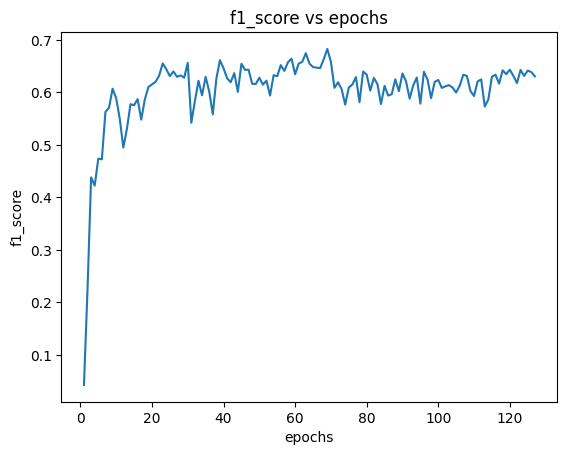

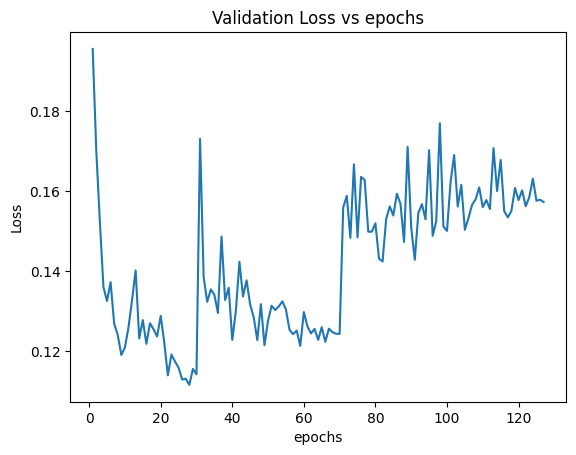

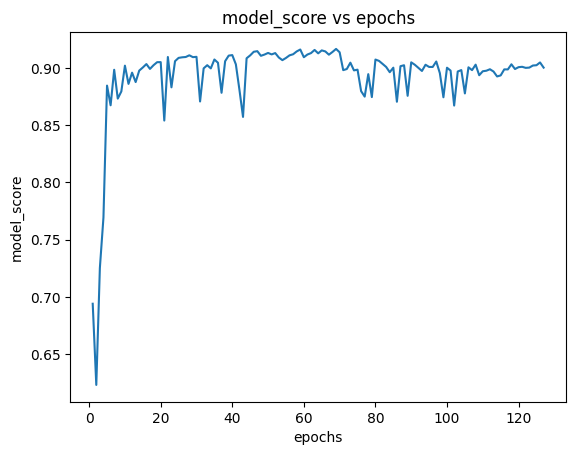

In [ ]:
plt.figure(1)
#plt.plot(sorted(list(set(roc_epochs))), f1_arr)
plt.plot(range(1,128), f1_arr)
plt.xlabel("epochs")
plt.ylabel("f1_score")
plt.title('f1_score vs epochs')

plt.figure(2)
#plt.plot(sorted(list(set(roc_epochs))), loss_arr)
plt.plot(range(1,128), loss_arr)
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.title('Validation Loss vs epochs')

plt.figure(3)
#plt.plot(sorted(list(set(roc_epochs))), f1_arr)
plt.plot(range(1,128), model_arr)
plt.xlabel("epochs")
plt.ylabel("model_score")
plt.title('model_score vs epochs')

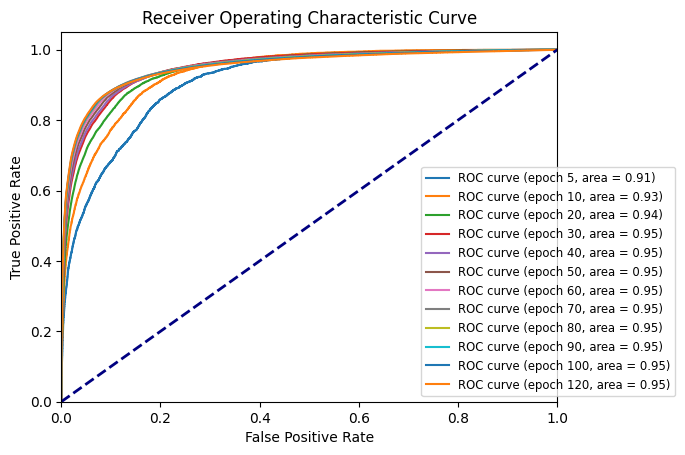

In [ ]:
# plot ROC curve
fig2, ax2 = plt.subplots()
for i in range(len(roc_auc)):
    ax2.plot(roc_fpr[i], roc_tpr[i], label=f'ROC curve (epoch {roc_epochs[i]}, area = {roc_auc[i]:.2f})')
ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('Receiver Operating Characteristic Curve')
# Set the properties for the legend
legend = ax2.legend(loc='lower right', bbox_to_anchor=(1.25, 0), fontsize='small', framealpha=0.8)